# Abstract

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Market Value Model 

In [2]:
value_all_players = pd.read_csv("upd_pldata.csv")

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

value_all_players.columns = value_all_players.columns.str.replace('.', '_')
value_all_players.columns = value_all_players.columns.str.replace('___', '_')
value_all_players.columns = value_all_players.columns.str.replace(' ', '_')

In [4]:
value_all_players.shape

(5700, 59)

## Preliminary Vizualizations

In [5]:
final_value_all_players = pd.DataFrame(value_all_players, columns = ["Name"])
final_value_all_players["actual"] = value_all_players['Value'].copy()

Text(0.5, 1.0, 'Value vs. Potential')

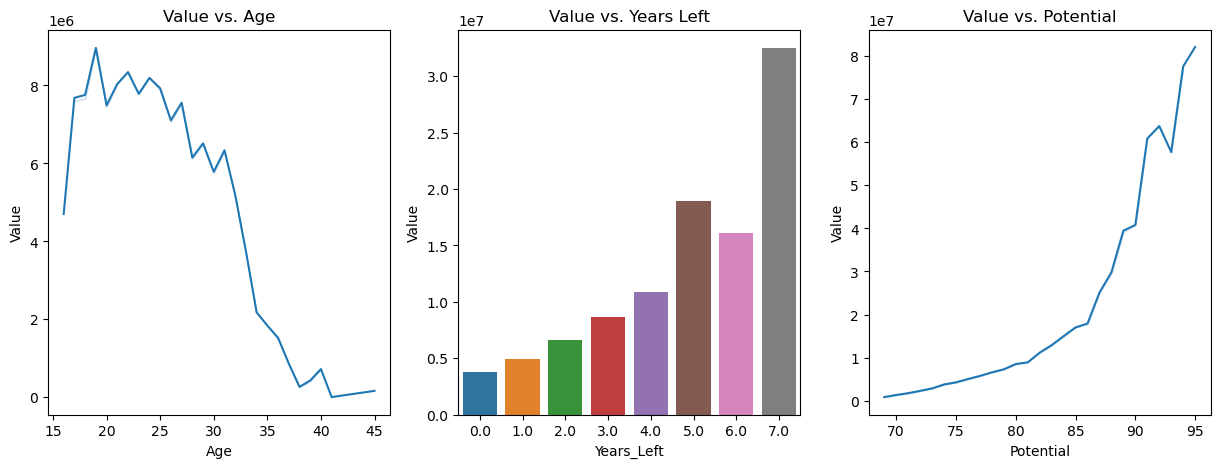

In [6]:
fig, axarr = plt.subplots(1, 3, figsize=(15,5), sharex = False, sharey = False)

sns.lineplot(data=value_all_players, x="Age", y="Value", errorbar=('ci', False), ax = axarr[0]).set_title('Value vs. Age')
sns.barplot(data=value_all_players, x=(value_all_players["Years_Left"]), y="Value", errorbar=('ci', False), ax = axarr[1]).set_title('Value vs. Years Left')
sns.lineplot(data=value_all_players, x="Potential", y="Value", errorbar=('ci', False), ax = axarr[2]).set_title('Value vs. Potential')

## Prepare Data for Modeling

In [14]:
from sklearn.model_selection import train_test_split
value_all_train, value_all_test = train_test_split(value_all_players, test_size = .2, shuffle = True)

#dropping categeorical info we won't use for modeling
value_all_train = value_all_train.drop(["Name", "field_position"], axis = 1)
value_all_test = value_all_test.drop(["Name", "field_position"], axis = 1)



#standardized and back to df
#Turn off for predictions?
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
value_all_train = pd.DataFrame(sc.fit_transform(value_all_train), columns = value_all_train.columns)
value_all_test = pd.DataFrame(sc.transform(value_all_test), columns = value_all_test.columns) #do NOT need to refit the standardization

#getting the target vector and deleting it from feature matrix

X_train_value = value_all_train.dropna(how='any', inplace=True)
X_train_value = value_all_train.drop(["Value"], axis = 1)
y_train_value = value_all_train["Value"]

 

X_test_value = value_all_test.dropna(how='any', inplace=True)
X_test_value = value_all_test.drop(["Value"], axis = 1)
y_test_value = value_all_test["Value"]

## Feature Selection

### Filter Approach w/ Univariate Statistical Tests

https://guhanesvar.medium.com/feature-selection-based-on-mutual-information-gain-for-classification-and-regression-d0f86ea5262a
https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

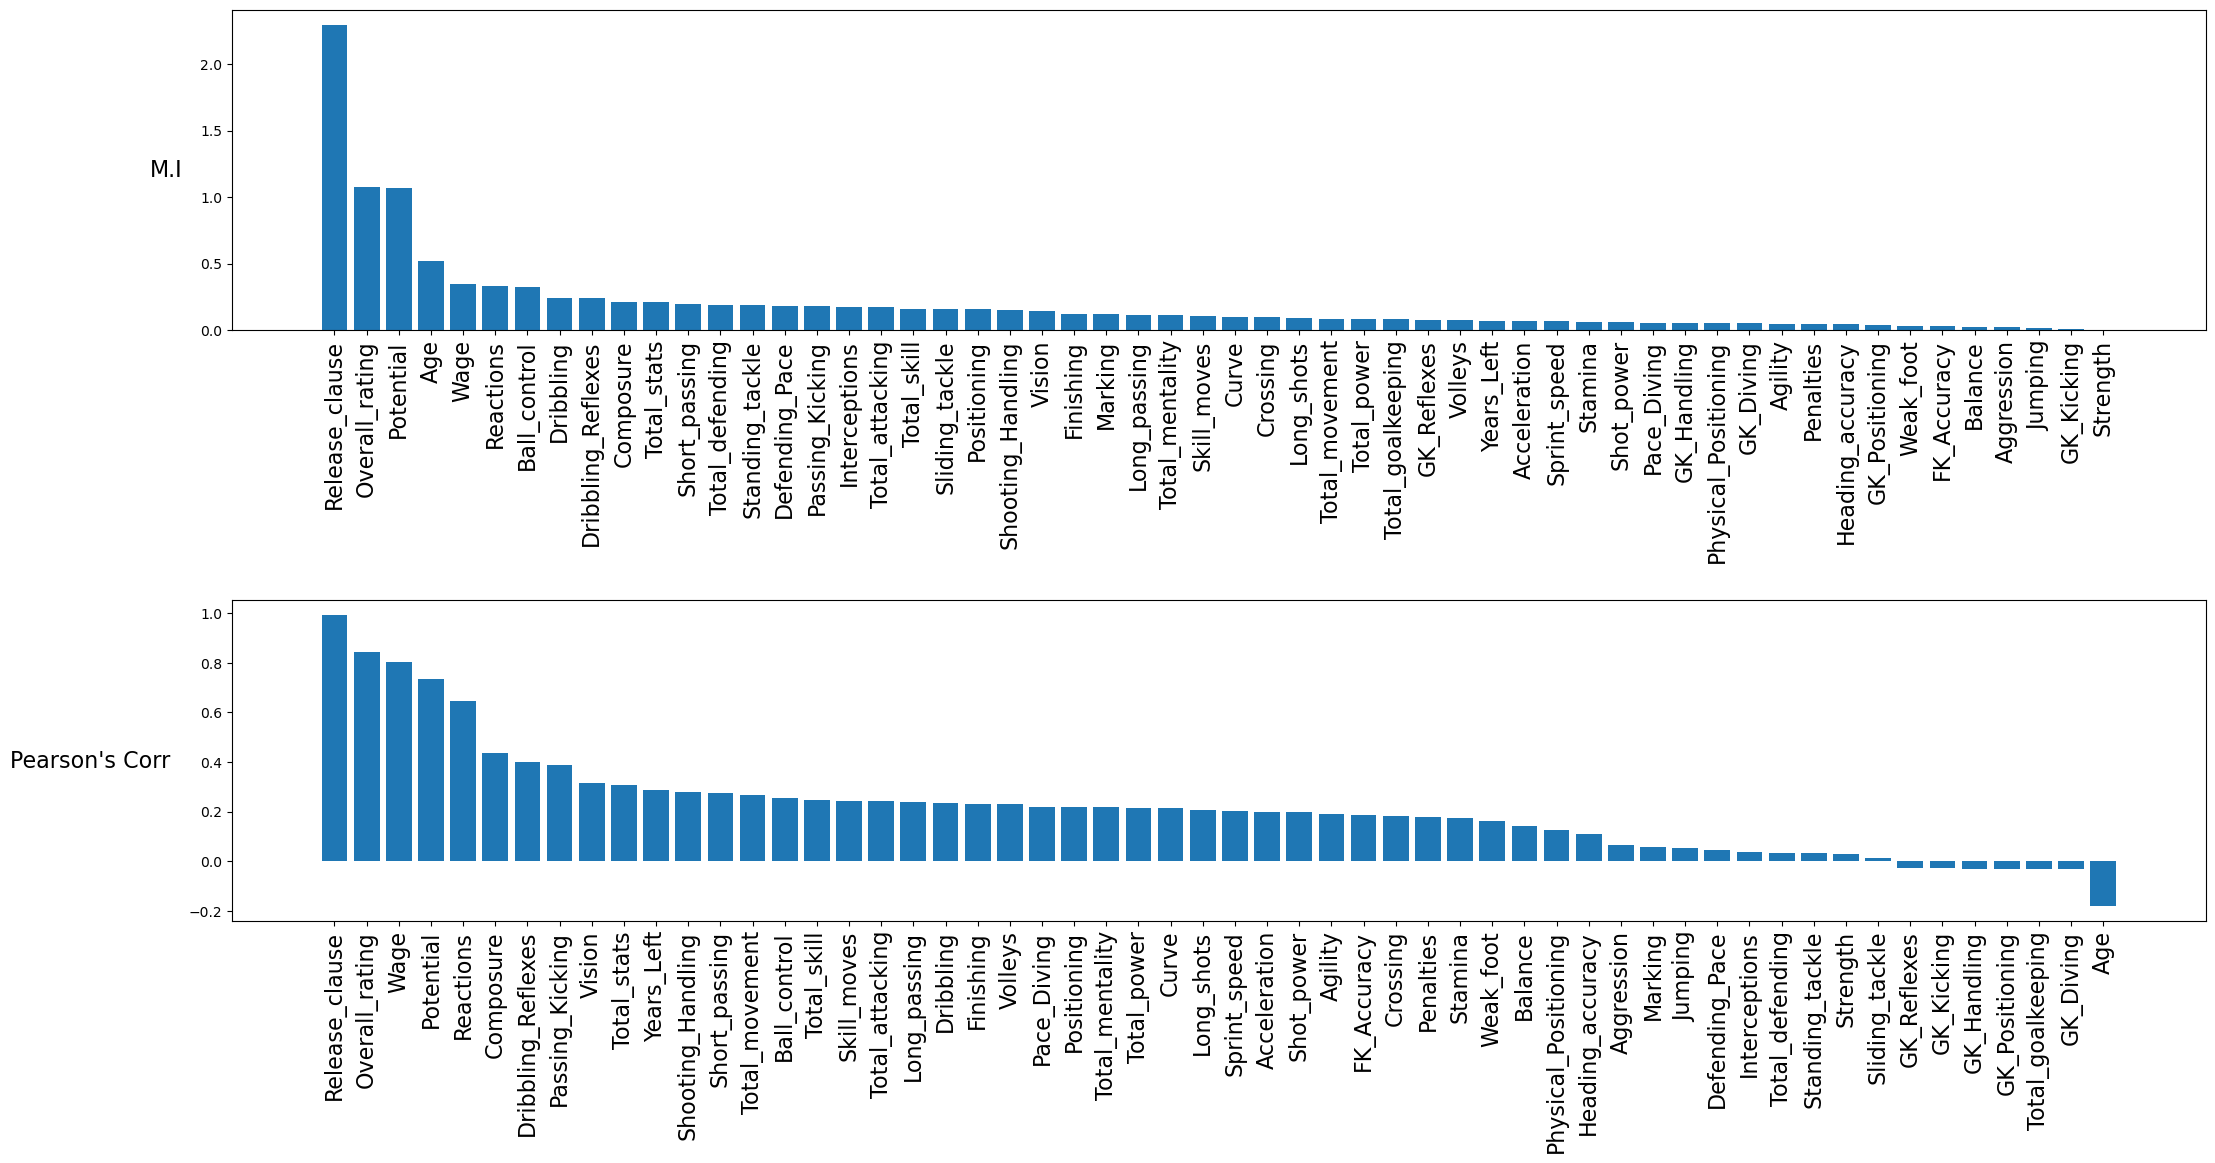

In [15]:
#create figure with 2 rows and 1 column. [row,column]
fig, axarr = plt.subplots(2, 1, figsize=(20,10), sharex = False, sharey = False)

#adjust rows
rows = ["M.I", "Pearson's Corr"]
for ax, row in zip(axarr[:], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=16, ha='right', va='center')

#adjust display
fig.tight_layout(w_pad = 0, h_pad = 18)
fig.subplots_adjust(left=0, top=0.95)
    

#Mutual Information
from sklearn.feature_selection import mutual_info_regression

mutual_info = mutual_info_regression(X_train_value, y_train_value)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_value.columns
axarr[0].bar(mutual_info.sort_values(ascending=False).index, mutual_info.sort_values(ascending=False))
axarr[0].tick_params('x', labelrotation=90, labelsize = 16)



#Pearson's Correlation
from sklearn.feature_selection import r_regression

pearson_corr = r_regression(X_train_value, y_train_value)
pearson_corr = pd.Series(pearson_corr)
pearson_corr.index = X_train_value.columns #assign correspondning column name to correlation scores
axarr[1].bar(pearson_corr.sort_values(ascending=False).index, pearson_corr.sort_values(ascending=False)) #.index gives us names in associated descending order
axarr[1].tick_params('x', labelrotation=90, labelsize = 16)

#### Selecting Best Features

#### Mutual Information

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

#select top 15 features
selected_top_columns = SelectKBest(mutual_info_regression, k=15) 
selected_top_columns.fit(X_train_value, y_train_value) 

#get all sammples associated to these features using the selected feature names as index 
X_train_value_m_info_sel = X_train_value[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]
X_test_value_m_info_sel = X_test_value[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]

#### ANOVA

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#select top 15 features
selected_top_columns = SelectKBest(f_regression, k=15)
selected_top_columns.fit(X_train_value, y_train_value)

#get all sammples associated to these features using the selected feature names as index 
X_train_value_f_reg_sel = X_train_value[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]
X_test_value_f_reg_sel = X_test_value[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]

Note: Using r_regression to select the k best features doesn't give much importance to negatively correlated features even though they might be important for predictive purposes. So, we used f_regression instead. 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression

### Recursive Feature Elimination w/ Cross-validation

#short explanation

56
['Age' 'Overall_rating' 'Potential' 'Years_Left' 'Total_stats' 'Wage'
 'Release_clause' 'Total_attacking' 'Crossing' 'Finishing'
 'Heading_accuracy' 'Short_passing' 'Volleys' 'Total_skill' 'Dribbling'
 'Curve' 'FK_Accuracy' 'Long_passing' 'Ball_control' 'Total_movement'
 'Acceleration' 'Sprint_speed' 'Agility' 'Reactions' 'Balance'
 'Total_power' 'Shot_power' 'Jumping' 'Stamina' 'Strength' 'Long_shots'
 'Total_mentality' 'Aggression' 'Interceptions' 'Positioning' 'Vision'
 'Penalties' 'Composure' 'Total_defending' 'Marking' 'Standing_tackle'
 'Sliding_tackle' 'Total_goalkeeping' 'GK_Diving' 'GK_Handling'
 'GK_Kicking' 'GK_Positioning' 'GK_Reflexes' 'Weak_foot' 'Skill_moves'
 'Pace_Diving' 'Shooting_Handling' 'Passing_Kicking' 'Dribbling_Reflexes'
 'Defending_Pace' 'Physical_Positioning']
7
['Overall_rating' 'Wage' 'Release_clause' 'Volleys' 'Weak_foot'
 'Skill_moves' 'Pace_Diving']
10
['Overall_rating' 'Wage' 'Release_clause' 'Ball_control' 'Reactions'
 'Composure' 'Total_defending'

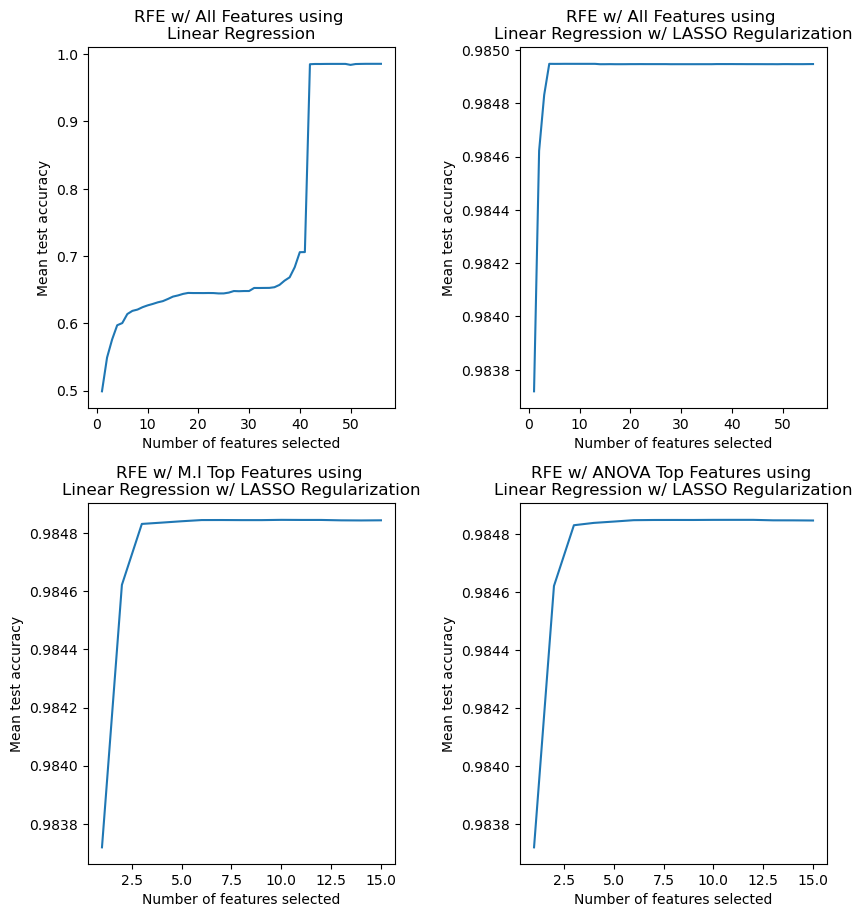

In [69]:
#create figure with 1 row and 3 columns. [row,column] 
fig, axarr = plt.subplots(2, 2, figsize=(9,9), sharex = False, sharey = False)
fig.tight_layout(w_pad = 7, h_pad = 5)
fig.subplots_adjust(left=0.15, top=0.95)


from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso


#all features RFECV w/ LR and NO regularization
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_value, y_train_value)

print(selector.n_features_)
print(selector.get_feature_names_out(X_train_value.columns))
#print the feature names too
#print(selector.cv_results_)
rfe_index = X_train_value.columns[selector.get_support()]
X_train_value_rfe = X_train_value[rfe_index]

#all features RFECV Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[0,0].plot(np.arange(n_scores) + 1, scores)
labs = axarr[0,0].set(title = "RFE w/ All Features using \nLinear Regression", xlabel = "Number of features selected", ylabel = "Mean test accuracy")


#all features RFECV w/ LR and LASSO regularization
estimator = Lasso(alpha = 0.01)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_value, y_train_value)

print(selector.n_features_)
print(selector.get_feature_names_out(X_train_value.columns))
#print the feature names too
#print(selector.cv_results_)
rfe_LASSO_index = X_train_value.columns[selector.get_support()]
X_train_value_rfe = X_train_value[rfe_LASSO_index]

#all features RFECV w/ LR and LASSO regularization Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[0,1].plot(np.arange(n_scores) + 1, scores)
labs = axarr[0,1].set(title = "RFE w/ All Features using \nLinear Regression w/ LASSO Regularization", xlabel = "Number of features selected", ylabel = "Mean test accuracy")


#MI Features RFECV

estimator = Lasso(alpha = 0.01)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_value_m_info_sel, y_train_value)

print(selector.n_features_)
print(selector.get_feature_names_out(X_train_value_m_info_sel.columns))
#print(selector.cv_results_)
mi_rfe_index = X_train_value_m_info_sel.columns[selector.get_support()]
X_train_value_mi_rfe = X_train_value_m_info_sel[mi_rfe_index]

#MI Features RFECV Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[1,0].plot(np.arange(n_scores) + 1, scores)
labs = axarr[1,0].set(title = "RFE w/ M.I Top Features using \nLinear Regression w/ LASSO Regularization", xlabel = "Number of features selected", ylabel = "Mean test accuracy")


#ANOVA Features RFECV

estimator = Lasso(alpha = 0.01)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_value_f_reg_sel, y_train_value)

print(selector.n_features_) # number of selected features
print(selector.get_feature_names_out(X_train_value_f_reg_sel.columns))#selected feature names


f_reg_rfe_index = selector.get_feature_names_out(X_train_value_f_reg_sel.columns)
X_train_value_f_reg_rfe = X_train_value[f_reg_rfe_index]
X_test_value_f_reg_rfe = X_test_value_f_reg_sel[f_reg_rfe_index]

#ANOVA Features RFECV Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[1,1].plot(np.arange(n_scores) + 1, scores)
labs = axarr[1,1].set(title = "RFE w/ ANOVA Top Features using \nLinear Regression w/ LASSO Regularization", xlabel = "Number of features selected", ylabel = "Mean test accuracy")

In [408]:
#BIG COMMENTARY
#our LR must be feeding it bad coefficients, problem with feature importance analysis. Could this be due to a lack of regularization + multicollinearity
#yep, try LASSO; yep
#https://stats.stackexchange.com/questions/450703/is-feature-importance-in-random-forest-useless

## Modeling

In [409]:
#which set should i take?? #least number of features seems like a valid idea

#choose the set with the least number of features to model on.
X_train_value_sel = X_train_value_f_reg_rfe
X_test_value_sel = X_test_value_f_reg_rfe

In [410]:
from sklearn.linear_model import Lasso
L = Lasso(alpha = 0.01)
L.fit(X_train_value_sel, y_train_value)
print(L.score(X_test_value_sel, y_test_value))
print(f"The model's score on the holdout test set is {L.score(X_test_value_sel, y_test_value)}")

from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(L, X_train_value_sel, y_train_value, cv=5)
print(f"The model's 5-fold cross-validation score is {(model_scores.mean())}")

sorted_ascend_params = np.argsort(LR.coef_) #Returns the indices that would sort an array in ascending order
sorted_descend_params = list(reversed(sorted_ascend_params))
print("Top 5 features that contribute the MOST to predicting transfer fee paid:")
print(X_train_value.columns[sorted_descend_params[-11:]]) #use as column names ; #match 

0.9812705103364381
The model's score on the holdout test set is 0.9812705103364381
The model's 5-fold cross-validation score is 0.9860187559686684
Top 5 features that contribute the MOST to predicting transfer fee paid:
Index(['Potential', 'Age', 'Overall_rating'], dtype='object')


In [411]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=5, random_state=0)
rfr.fit(X_train_value_sel, y_train_value)
print(f"The model's score on the holdout test set is {rfr.score(X_test_value_sel, y_test_value)}")

from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(rfr, X_train_value_sel, y_train_value, cv=5)
print(f"The model's 5-fold cross-validation score is {(model_scores.mean())}")

sorted_ascend_params = np.argsort(rfr.feature_importances_) #Returns the indices that would sort an array in ascending order
sorted_descend_params = list(reversed(sorted_ascend_params))
print("Top 5 features that contribute the MOST to predicting transfer fee paid:")
print(X_train_value_sel.columns[sorted_descend_params[:5]]) #use as column names ; #match 

The model's score on the holdout test set is 0.9804419658234721
The model's 5-fold cross-validation score is 0.9842980065948834
Top 5 features that contribute the MOST to predicting transfer fee paid:
Index(['Release_clause', 'Overall_rating', 'Reactions', 'Wage', 'Composure'], dtype='object')


#### Mini-Experiment: Cross Validation Run Time (based on # of selected features)

In [306]:
#cross-validation w/ all features
import time as tm
start = tm.time()

from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(regr, X_train_value, y_train_value, cv=5)
print(f"Using all features, the model's 5-fold cross-validation score is {(model_scores.mean())}")


running_secs = (tm.time() - start)
print(f"Run time: {running_secs}")

#cross-validation w/ selected features
import time as tm
start = tm.time()

from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(regr, X_train_value_sel, y_train_value, cv=5)
print(f"Using selected features, the model's 5-fold cross-validation score is {(model_scores.mean())}")

running_secs = (tm.time() - start)
print(f"Run time: {running_secs}")

Using all features, the model's 5-fold cross-validation score is 0.9851166075837202
Run time: 0.05238699913024902
Using selected features, the model's 5-fold cross-validation score is 0.9850273473927451
Run time: 0.019578933715820312


#### Take-Aways: Less features provides faster results for our RandomForestRegressor

## Model Performance hmm, don't need this here!

In [412]:
#test set score arrays
L_pf = []
rfr_pf = []

#cross-val score arrays
L_pf_cv = []
rfr_pf_cv = []

for i in range(1,10):
    #prepare for modeling
    
    from sklearn.model_selection import train_test_split
    value_all_train, value_all_test = train_test_split(value_all_players, test_size = .2, shuffle = True)

    #dropping categeorical info we won't use for modeling
    value_all_train = value_all_train.drop(["Name", "field_position"], axis = 1)
    value_all_test = value_all_test.drop(["Name", "field_position"], axis = 1)



    #standardized and back to df
    #Turn off for predictions?
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    value_all_train = pd.DataFrame(sc.fit_transform(value_all_train), columns = value_all_train.columns)
    value_all_test = pd.DataFrame(sc.transform(value_all_test), columns = value_all_test.columns) #do NOT need to refit the standardization

    #getting the target vector and deleting it from feature matrix

    X_train_value = value_all_train.dropna(how='any', inplace=True)
    X_train_value = value_all_train.drop(["Value"], axis = 1)
    y_train_value = value_all_train["Value"]



    X_test_value = value_all_test.dropna(how='any', inplace=True)
    X_test_value = value_all_test.drop(["Value"], axis = 1)
    y_test_value = value_all_test["Value"]
    
    #using selected features ANOVA + RFE
    X_train_value_sel = X_train_value[f_reg_rfe_index] 
    X_test_value_sel = X_test_value[f_reg_rfe_index]
    


    L = Lasso(alpha = 0.01)
    L.fit(X_train_value_sel, y_train_value)
    L_pf.append(L.score(X_test_value_sel, y_test_value))
    
    
    model_scores = cross_val_score(LR, X_train_value_sel, y_train_value, cv=5)
    L_pf_cv.append((model_scores.mean()))

In [413]:
print(np.mean(L_pf))
print(np.mean(L_pf_cv))

0.9857558940050496
0.9849533376763533


#### Take-Aways: 
- Performace:  
- Mini-Experiment: Huge discrepancy between holdout method and cross validation method, due to sample size??? double check with larger dataset, and do an experiment

## Visualizations
#combine into one fig!! + try w/ and w/out standardization
https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots

#### Preliminary

In [370]:
#Need to use unstandardized data for the predictions and actual trasnfer market values to be in millions

In [414]:
#reverse standardization done in the prepare for modeling step
value_all_train = pd.DataFrame(sc.inverse_transform(value_all_train), columns = value_all_train.columns)
value_all_test = pd.DataFrame(sc.inverse_transform(value_all_test), columns = value_all_test.columns) #do NOT need to refit the standardization

#re-establish feature matrix and target vector
X_train_value = value_all_train.dropna(how='any', inplace=True)
X_train_value = value_all_train.drop(["Value"], axis = 1)
y_train_value = value_all_train["Value"]

 

X_test_value = value_all_test.dropna(how='any', inplace=True)
X_test_value = value_all_test.drop(["Value"], axis = 1)
y_test_value = value_all_test["Value"]

#use the selected features (ANOVA + RFE)
X_train_value_sel = X_train_value[f_reg_rfe_index] 
X_test_value_sel = X_test_value[f_reg_rfe_index]

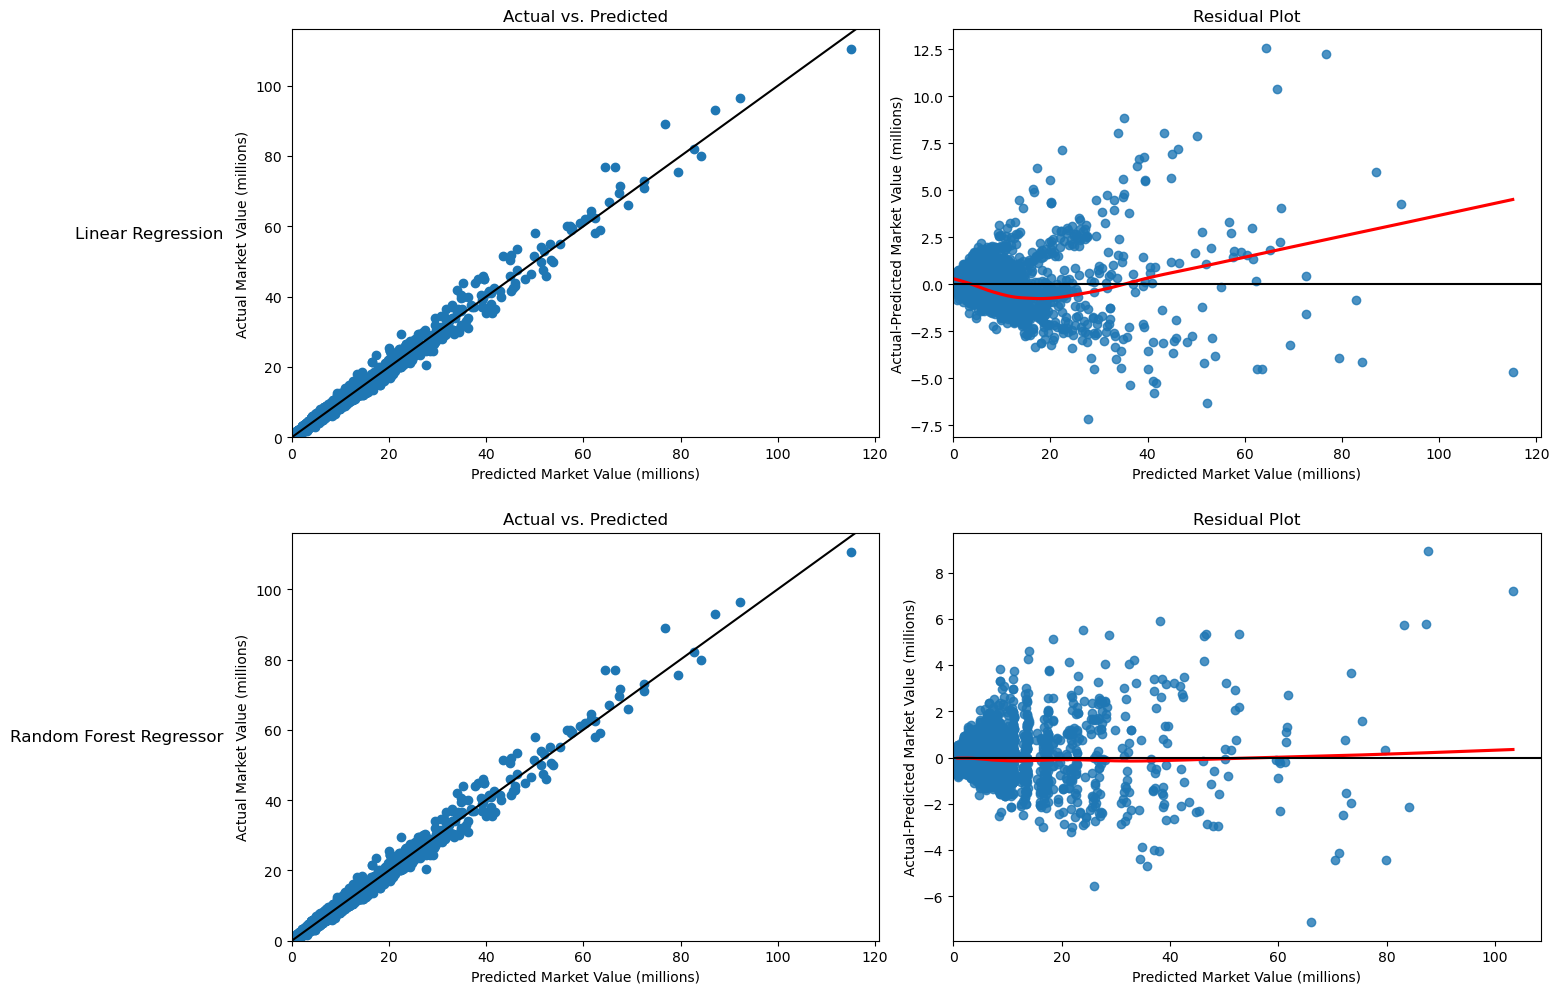

In [420]:
fig, axarr = plt.subplots(2, 2, figsize=(15,10), sharex = False, sharey = False)

rows = ["Linear Regression", "Random Forest Regressor"]
for ax, row in zip(axarr[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
fig.tight_layout(w_pad = 2, h_pad = 5)
fig.subplots_adjust(left=0.15, top=0.95)
    
#Lasso
L.fit(X_train_value_sel, y_train_value)
L.predict(X_train_value_sel)
predictions12 = L.predict(X_train_value_sel)/1000000
actual = y_train_value/1000000

difference = np.subtract(actual, predictions12)

#plot actual vs. prediction + paramater line
axarr[0,0].axline((0, 0), slope=1, color = "black")
axarr[0,0].scatter(x = predictions12, y = actual)
axarr[0,0].axis(xmin=0,ymin=0)

#plot the residuals
sns.regplot(x = predictions12, y = difference, lowess=True, line_kws=dict(color="r"), ax = axarr[0,1])
axarr[0,1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[0,1].axis(xmin=0)



#graph descriptives
labs = axarr[0,0].set(title = "Actual vs. Predicted", xlabel = "Predicted Market Value (millions)", ylabel = "Actual Market Value (millions)")
labs = axarr[0,1].set(title = "Residual Plot", xlabel = "Predicted Market Value (millions)", ylabel = "Actual-Predicted Market Value (millions)") #add legend


#RFR
rfr.fit(X_train_value_sel, y_train_value)
rfr.predict(X_train_value_sel)
predictions123 = rfr.predict(X_train_value_sel)/1000000
actual = y_train_value/1000000

difference = np.subtract(actual, predictions123)

#plot actual vs. prediction + paramater line
axarr[1,0].axline((0, 0), slope=1, color = "black")
axarr[1,0].scatter(x = predictions12, y = actual)
axarr[1,0].axis(xmin=0,ymin=0)

#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = predictions123, y = difference, lowess=True, line_kws=dict(color="r"))
axarr[1,1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1,1].axis(xmin=0)

#graph descriptions
labs = axarr[1,0].set(title = "Actual vs. Predicted", xlabel = "Predicted Market Value (millions)", ylabel = "Actual Market Value (millions)")
labs = axarr[1,1].set(title = "Residual Plot", xlabel = "Predicted Market Value (millions)", ylabel = "Actual-Predicted Market Value (millions)") #add legend

In [ ]:
#commentary!!!

# Tranfer Fee Model (updated)

## Import appropriate dataset

In [7]:
tf2_data = pd.read_csv("changed_fifa_transfer fee_final.csv")
tf2_data.shape #dimensions

(708, 78)

In [8]:
#clean column names
tf2_data.columns = tf2_data.columns.str.replace('.', '_')
tf2_data.columns = tf2_data.columns.str.replace('___', '_')
tf2_data.columns = tf2_data.columns.str.replace(' ', '_')

/var/folders/x_/pzlfspq52sd41dygb97kcztm0000gn/T/ipykernel_42248/373811230.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tf2_data.columns = tf2_data.columns.str.replace('.', '_')


In [9]:
tf2_data.head(3)

,age,fee_cleaned,value_eur,years_left,team,player_name,overall,potential,wage_eur,nationality_name,...,npxGA,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff,SPI,tranfer_activity
0,27,13.0,7500000.0,1,Barcelona,Jasper Cillessen,79,82,90000.0,Netherlands,...,33.28594,66.191080,6.012152,15.064390,570,163,94.3800,3.3800,67.72,-487.0
1,22,16.5,3800000.0,2,Barcelona,Lucas Digne,76,83,70000.0,France,...,33.28594,66.191080,6.012152,15.064390,570,163,94.3800,3.3800,67.72,-487.0
2,25,1.5,425000.0,3,Eibar,Florian Lejeune,65,70,2000.0,France,...,47.45242,-0.608427,7.804410,7.974349,191,218,54.0253,11.0253,67.72,-487.0


In [10]:
#getting gk datasets
tf2_data_gk_index = tf2_data["position_x"] == "Goalkeeper"
tf2_data_gk = tf2_data[tf2_data_gk_index]

tf2_data_gk_index_2 = tf2_data_gk["fee_cleaned"] > 0
tf2_data_gk = tf2_data_gk[tf2_data_gk_index_2]

tf2_data_gk_index_3 = tf2_data_gk["years_left"] > 0
tf2_data_gk = tf2_data_gk[tf2_data_gk_index_3]

tf2_data_gk = tf2_data_gk.dropna(axis = 1)

In [11]:
tf2_data_gk.shape

(37, 72)

In [12]:
#getting data for field players
tf2_data_field_index = tf2_data["position_x"] != "Goalkeeper"
tf2_data_field = tf2_data[tf2_data_field_index]

tf2_data_field["fee_cleaned"] = tf2_data_field["fee_cleaned"] * 1000000


tf2_data_field_index_2 = tf2_data_field["fee_cleaned"] > 0
tf2_data_field = tf2_data_field[tf2_data_field_index_2]

tf2_data_field_index_3 = tf2_data_field["years_left"] > 0
tf2_data_field = tf2_data_field[tf2_data_field_index_3]

tf2_data_field = tf2_data_field.dropna()

/var/folders/x_/pzlfspq52sd41dygb97kcztm0000gn/T/ipykernel_42248/2135113622.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf2_data_field["fee_cleaned"] = tf2_data_field["fee_cleaned"] * 1000000


In [13]:
tf2_data_field.shape

(414, 78)

NOTE: Goalkeeper dataset has very few samples, so we decided to omit and model only on field players dataset.

## Preliminary Data Analysis (Visualizations + Tables)

Text(0.5, 1.0, 'Transfer fee vs. Potential')

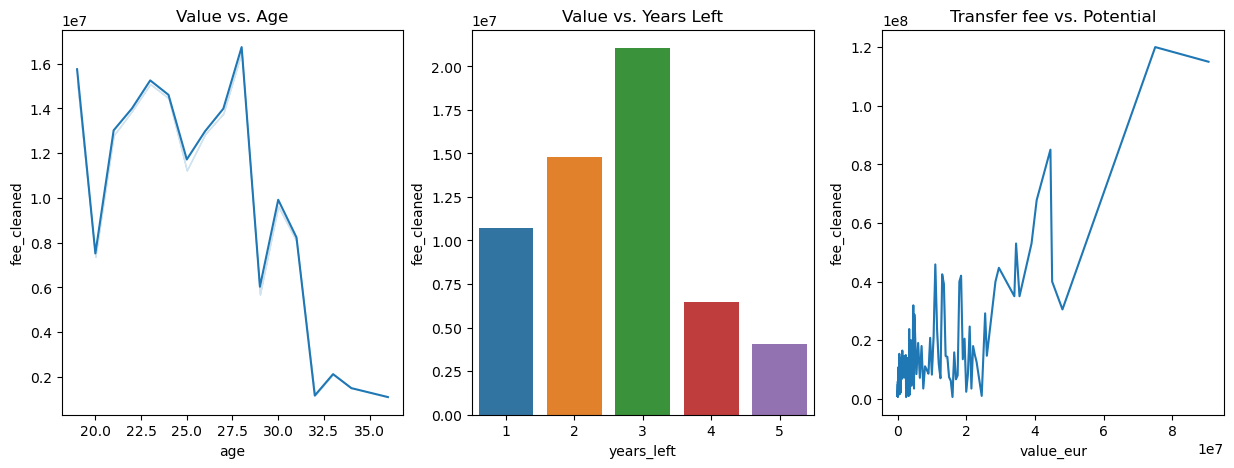

In [14]:
fig, axarr = plt.subplots(1, 3, figsize=(15,5), sharex = False, sharey = False)

sns.lineplot(data=tf2_data_field, x="age", y="fee_cleaned", errorbar=('ci', False), ax = axarr[0]).set_title('Value vs. Age')
sns.barplot(data=tf2_data_field, x= "years_left", y="fee_cleaned", errorbar=('ci', False), ax = axarr[1]).set_title('Value vs. Years Left')
sns.lineplot(data=tf2_data_field, x="value_eur", y="fee_cleaned", errorbar=('ci', False), ax = axarr[2]).set_title('Transfer fee vs. Potential')
#sns.lineplot(data = tf2_data_field, x = "value_eur", y = "fee_cleaned", ci = False,  ax = axarr[4]).set_title('Value vs. Potential')

## Preparing Data For Modeling + Feature Engineering

In [15]:
from sklearn.model_selection import train_test_split
field_tf_upd_train, field_tf_upd_test = train_test_split(tf2_data_field, test_size = .2, shuffle = True)


#re-clean; drop categorical, keep numerical
field_tf_upd_train = field_tf_upd_train.drop(["player_name","nationality_name","position_x","league_name_x_y"], axis = 1)
field_tf_upd_test= field_tf_upd_test.drop(["player_name","nationality_name","position_x","league_name_x_y"], axis = 1)


#feature engineering on training data
buyer_avg_tf = field_tf_upd_train.groupby("team")["fee_cleaned"].mean()
seller_avg_tf = field_tf_upd_train.groupby("club_involved_name")["fee_cleaned"].mean()

#left-merge based on "team names"; preserves all rows of tf2_data_field and merges with buyer_avg_tf on matches on "team"
field_tf_upd_train = pd.merge(field_tf_upd_train, buyer_avg_tf, on='team', how='left', suffixes=('', '_buyer_avg'))
field_tf_upd_train = pd.merge(field_tf_upd_train, seller_avg_tf, on='club_involved_name', how='left', suffixes=('', '_seller_avg'))

#drop the categorical features we used for feature engineering
field_tf_upd_train = field_tf_upd_train.drop(["team"], axis = 1)
field_tf_upd_train = field_tf_upd_train.drop(["club_involved_name"], axis = 1)


#feature engineering on testing data (added after improved performance on cross-validated scores was observed)
buyer_avg_tf = field_tf_upd_test.groupby("team")["fee_cleaned"].mean()
seller_avg_tf = field_tf_upd_test.groupby("club_involved_name")["fee_cleaned"].mean()

#left-merge based on "team names"; preserves all rows of tf2_data_field and merges with buyer_avg_tf on matches on "team"
field_tf_upd_test = pd.merge(field_tf_upd_test, buyer_avg_tf, on='team', how='left', suffixes=('', '_buyer_avg'))
field_tf_upd_test = pd.merge(field_tf_upd_test, seller_avg_tf, on='club_involved_name', how='left', suffixes=('', '_seller_avg'))

#drop the categorical features we used for feature engineering
field_tf_upd_test = field_tf_upd_test.drop(["team"], axis = 1)
field_tf_upd_test = field_tf_upd_test.drop(["club_involved_name"], axis = 1)


# #TURN OFF FOR PREDICTIONS
# #standardized and back to df
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
field_tf_upd_train = pd.DataFrame(sc.fit_transform(field_tf_upd_train), columns = field_tf_upd_train.columns)
field_tf_upd_test = pd.DataFrame(sc.transform(field_tf_upd_test), columns = field_tf_upd_test.columns)


#Choosing target vector, droping from feature matrix
X_train_fee = field_tf_upd_train.drop(["fee_cleaned"], axis = 1)
y_train_fee = field_tf_upd_train["fee_cleaned"]

X_test_fee = field_tf_upd_test.drop(["fee_cleaned"], axis = 1)
y_test_fee = field_tf_upd_test["fee_cleaned"]

## Feature selection

/var/folders/x_/pzlfspq52sd41dygb97kcztm0000gn/T/ipykernel_42248/2691497170.py:22: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  axarr[0].bar(X_train_fee.columns[0:30], mutual_info.sort_values(ascending = False)[0:30], width = 0.5)


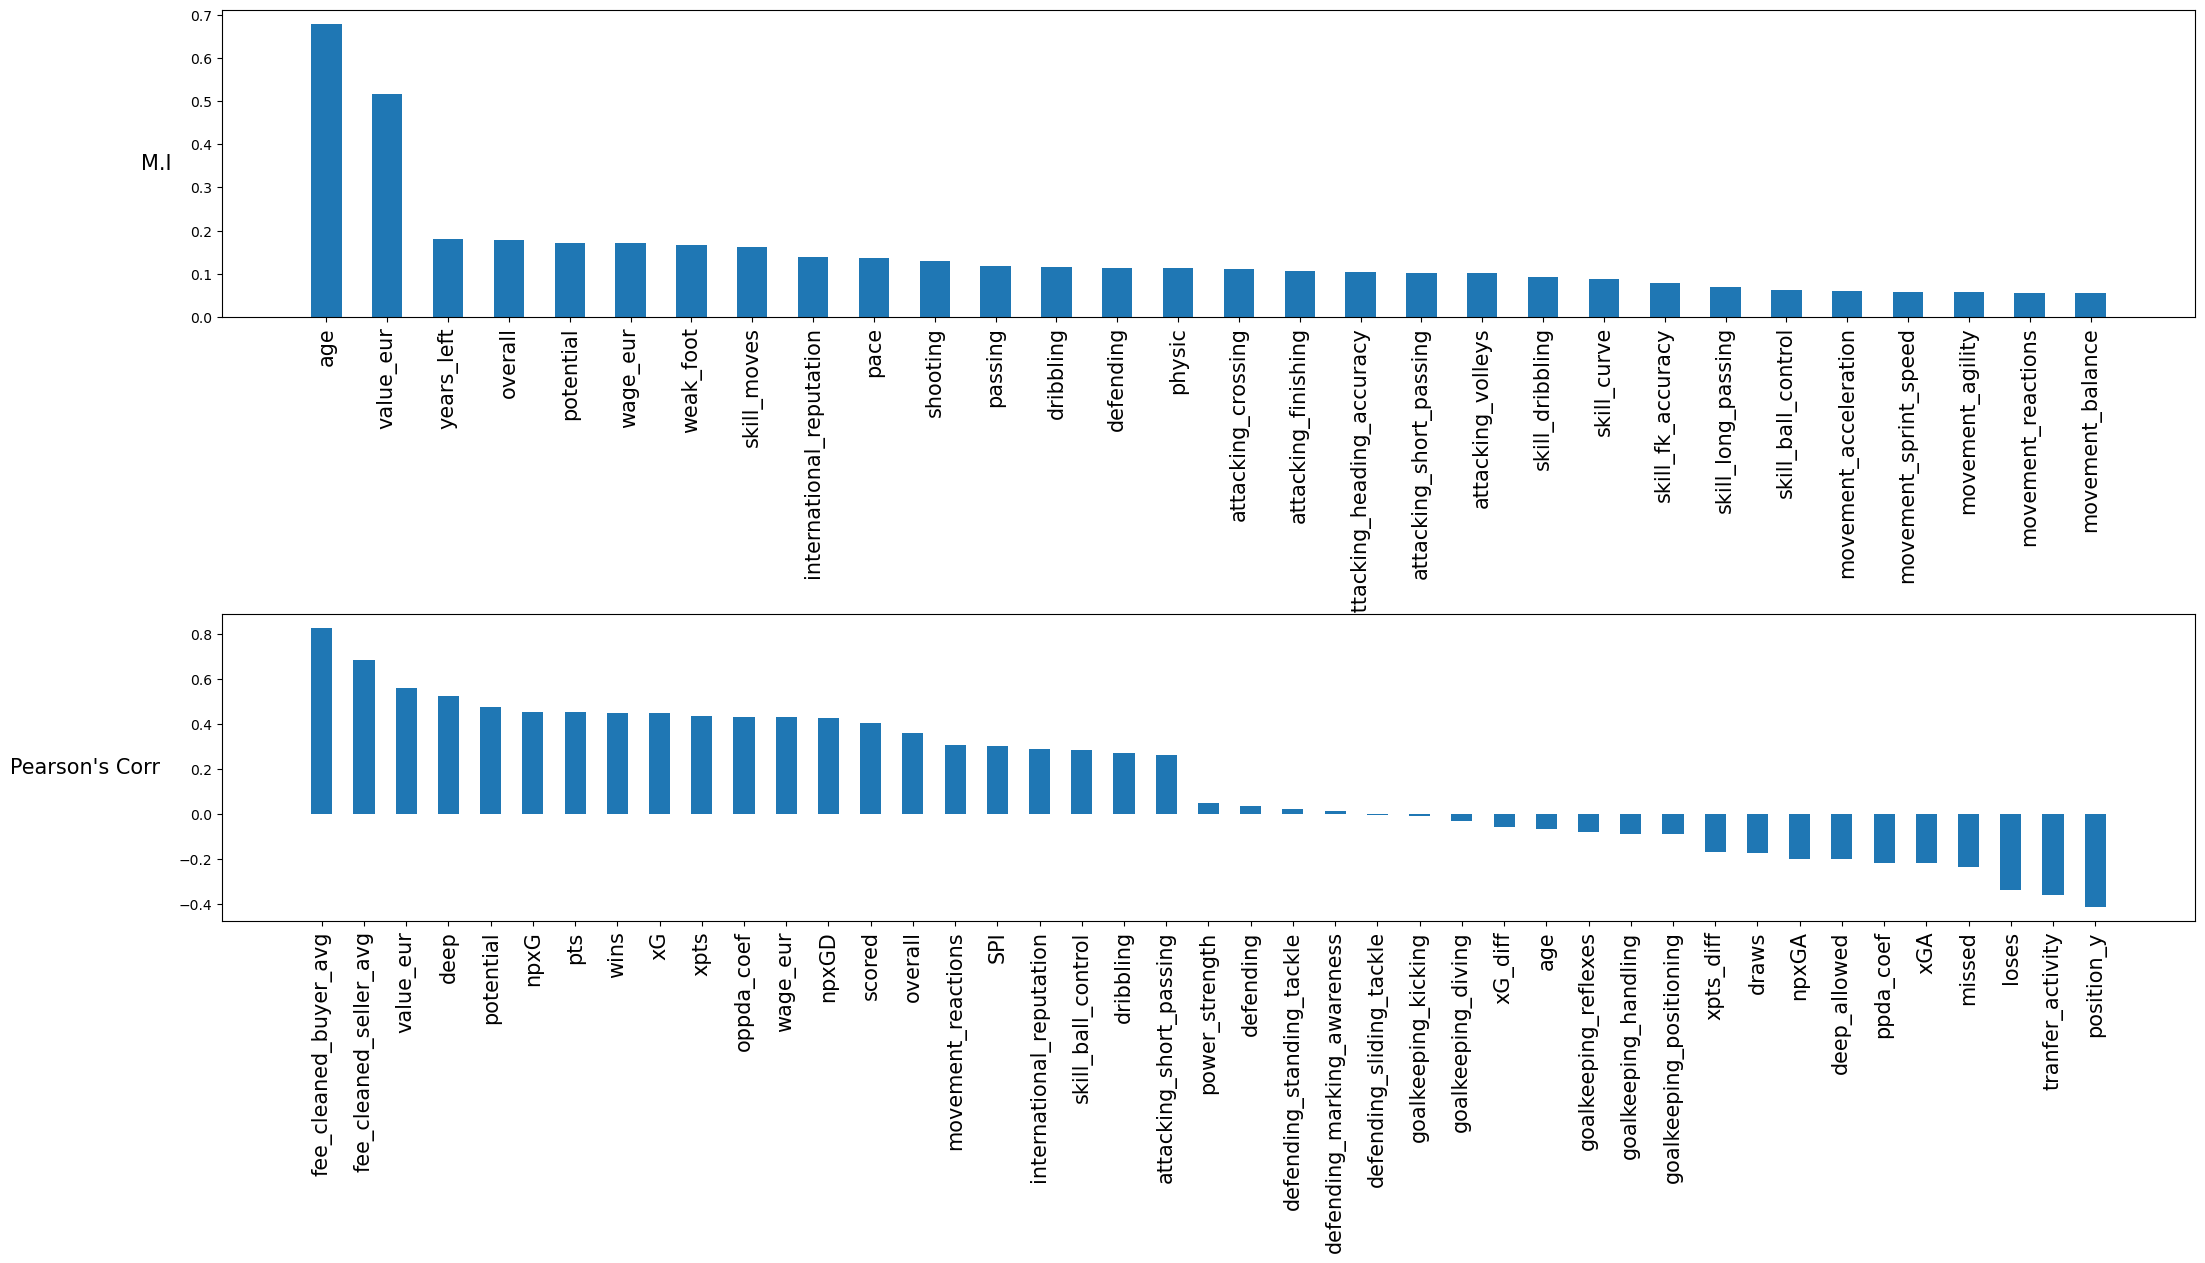

In [16]:
#create figure with 2 rows and 1 column. [row,column]
fig, axarr = plt.subplots(2, 1, figsize=(20,10), sharex = False, sharey = False)

#adjust rows
rows = ["M.I", "Pearson's Corr"]
for ax, row in zip(axarr[:], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=15, ha='right', va='center')

#adjust display
fig.tight_layout(w_pad = 0, h_pad = 20)
fig.subplots_adjust(left=0, top=0.95)
    

#Mutual Information
from sklearn.feature_selection import mutual_info_regression

mutual_info = mutual_info_regression(X_train_fee, y_train_fee)
mutual_info = pd.Series(mutual_info)

axarr[0].bar(X_train_fee.columns[0:30], mutual_info.sort_values(ascending = False)[0:30], width = 0.5) 
axarr[0].tick_params('x', labelrotation=90, labelsize = 15)



#Pearson's Correlation
from sklearn.feature_selection import r_regression

pearson_corr = r_regression(X_train_fee, y_train_fee)
pearson_corr = pd.Series(pearson_corr)
pearson_corr.index = X_train_fee.columns #assign correspondning column name to correlation scores
pearson_corr = pearson_corr.sort_values(ascending = False)

# #slice out middle values
middle_index = len(pearson_corr) // 2
corr_vals = np.concatenate((pearson_corr[:middle_index-15], pearson_corr[middle_index+15:]))
col_names = (np.concatenate((pearson_corr.index[:middle_index-15], pearson_corr.index[middle_index+15:])))

axarr[1].bar(col_names, corr_vals, width = 0.5)
axarr[1].tick_params('x', labelrotation=90, labelsize = 15)

#### Selecting Best Features

#### Mutual Information

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

#select top 15 features
selected_top_columns = SelectKBest(mutual_info_regression, k=15) 
selected_top_columns.fit(X_train_fee, y_train_fee) 

#get all sammples associated to these features using the selected feature names as index 
X_train_fee_m_info_sel = X_train_fee[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]
X_test_fee_m_info_sel = X_test_fee[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]

#### ANOVA

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#select top 15 features
selected_top_columns = SelectKBest(f_regression, k=15)
selected_top_columns.fit(X_train_fee, y_train_fee)

#get all sammples associated to these features using the selected feature names as index 
X_train_fee_f_reg_sel = X_train_fee[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]
X_test_fee_f_reg_sel = X_test_fee[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]

Note: Using r_regression to select the k best features doesn't give much importance to negatively correlated features even though they might be important for predictive purposes. So, we used f_regression instead. 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression

In [19]:
### Normal LR, performs worse without the filter feature selection; visual?

In [20]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_fee, y_train_fee)
# lr.score(X_test_fee, y_test_fee)

from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(lr, X_train_fee, y_train_fee, cv=30)
print(model_scores.mean())

-0.8969563263011803


### Recursive Feature Elimination w/ Cross-validation

#short explanation
#used Lasso cuz it's much faster than RFR

6
['value_eur' 'xG' 'xGA' 'npxGD' 'fee_cleaned_buyer_avg'
 'fee_cleaned_seller_avg']
4
['age' 'value_eur' 'fee_cleaned_buyer_avg' 'fee_cleaned_seller_avg']
3
['potential' 'fee_cleaned_buyer_avg' 'fee_cleaned_seller_avg']
3
['value_eur' 'fee_cleaned_buyer_avg' 'fee_cleaned_seller_avg']


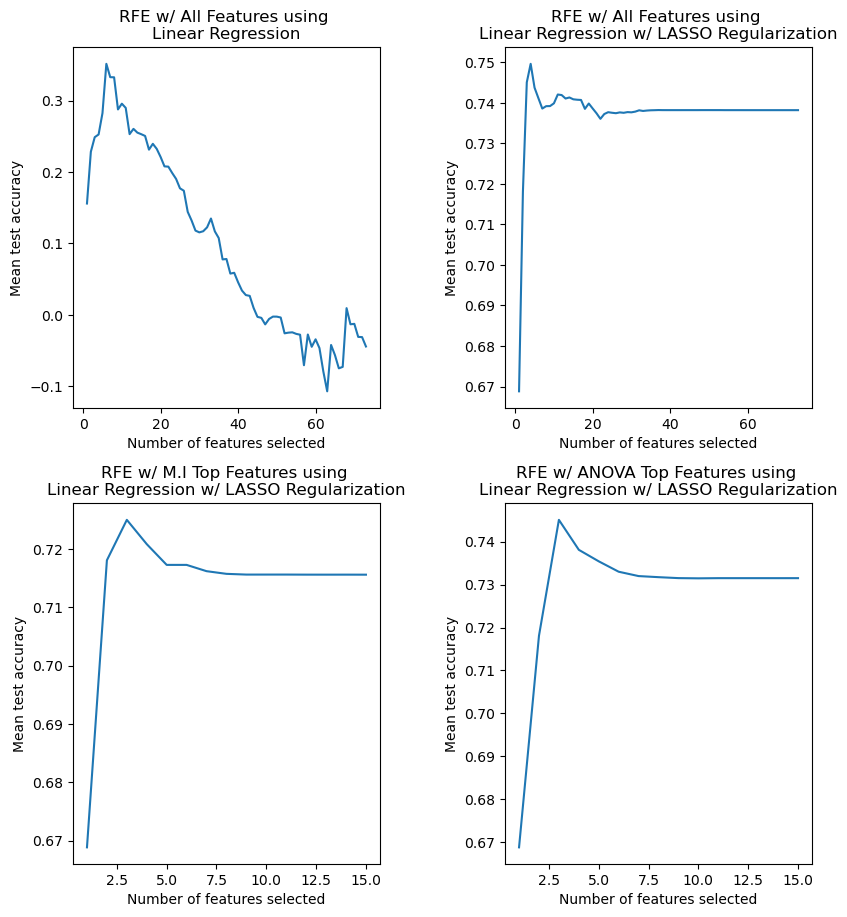

In [28]:
#create figure with 1 row and 3 columns. [row,column] 
fig, axarr = plt.subplots(2, 2, figsize=(9,9), sharex = False, sharey = False)
fig.tight_layout(w_pad = 7, h_pad = 5)
fig.subplots_adjust(left=0.15, top=0.95)


from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso



#all features RFECV w/ LR and NO regularization
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=20)
selector = selector.fit(X_train_fee, y_train_fee)

print(selector.n_features_)
print(selector.get_feature_names_out(X_train_fee.columns))
#print the feature names too
#print(selector.cv_results_)
rfe_index = X_train_fee.columns[selector.get_support()]
X_train_fee_rfe = X_train_fee[rfe_index]

#all features RFECV Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[0,0].plot(np.arange(n_scores) + 1, scores)
labs = axarr[0,0].set(title = "RFE w/ All Features using \nLinear Regression", xlabel = "Number of features selected", ylabel = "Mean test accuracy")


#all features RFECV w/ LR and LASSO regularization
estimator = Lasso(alpha = 0.01)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_fee, y_train_fee)

print(selector.n_features_)
print(selector.get_feature_names_out(X_train_fee.columns))
#print the feature names too
#print(selector.cv_results_)
rfe_LASSO_index = X_train_fee.columns[selector.get_support()]
X_train_fee_rfe = X_train_fee[rfe_LASSO_index]

#all features RFECV w/ LR and LASSO regularization Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[0,1].plot(np.arange(n_scores) + 1, scores)
labs = axarr[0,1].set(title = "RFE w/ All Features using \nLinear Regression w/ LASSO Regularization", xlabel = "Number of features selected", ylabel = "Mean test accuracy")


#MI Features RFECV

estimator = Lasso(alpha = 0.01)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_fee_m_info_sel, y_train_fee)

print(selector.n_features_)
print(selector.get_feature_names_out(X_train_fee_m_info_sel.columns))
#print(selector.cv_results_)
mi_rfe_index = X_train_fee_m_info_sel.columns[selector.get_support()]
X_train_fee_mi_rfe = X_train_fee_m_info_sel[mi_rfe_index]

#MI Features RFECV Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[1,0].plot(np.arange(n_scores) + 1, scores)
labs = axarr[1,0].set(title = "RFE w/ M.I Top Features using \nLinear Regression w/ LASSO Regularization", xlabel = "Number of features selected", ylabel = "Mean test accuracy")


#ANOVA Features RFECV

estimator = Lasso(alpha = 0.01)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_fee_f_reg_sel, y_train_fee)

print(selector.n_features_) # number of selected features
print(selector.get_feature_names_out(X_train_fee_f_reg_sel.columns))#selected feature names


f_reg_rfe_index = selector.get_feature_names_out(X_train_fee_f_reg_sel.columns)
X_train_fee_f_reg_rfe = X_train_fee_f_reg_sel[f_reg_rfe_index]
X_test_fee_f_reg_rfe = X_test_fee_f_reg_sel[f_reg_rfe_index]

#ANOVA Features RFECV Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[1,1].plot(np.arange(n_scores) + 1, scores)
labs = axarr[1,1].set(title = "RFE w/ ANOVA Top Features using \nLinear Regression w/ LASSO Regularization", xlabel = "Number of features selected", ylabel = "Mean test accuracy")

## Modeling

In [30]:
#which set should i take?? #least number of features seems like a valid idea

#choose the set with the least number of features to model on.
X_train_fee_sel = X_train_fee_f_reg_rfe
X_test_fee_sel = X_test_fee_f_reg_rfe

In [49]:
from sklearn.linear_model import Lasso
L = Lasso(alpha = 0.01)
L.fit(X_train_fee_sel, y_train_fee)
print(f"The model's score on the holdout test set is {L.score(X_test_fee_sel, y_test_fee)}")

from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(L, X_train_fee_sel, y_train_fee, cv=5)
print(f"The model's 5-fold cross-validation score is {(model_scores.mean())}")

sorted_ascend_params = np.argsort(L.coef_) #Returns the indices that would sort an array in ascending order
sorted_descend_params = list(reversed(sorted_ascend_params))
print("Top 5 features that contribute the MOST to predicting transfer fee paid:")
print(X_test_fee_sel.columns[sorted_descend_params[-11:]]) #use as column names ; #match 

The model's score on the holdout test set is 0.9010183471023727
The model's 5-fold cross-validation score is 0.7450560310434684
Top 5 features that contribute the MOST to predicting transfer fee paid:
Index(['fee_cleaned_buyer_avg', 'fee_cleaned_seller_avg', 'value_eur'], dtype='object')


In [57]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=7, random_state=0)
rfr.fit(X_train_fee_sel, y_train_fee)
print(f"The model's score on the holdout test set is {rfr.score(X_test_fee_sel, y_test_fee)}")

from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(rfr, X_train_fee_sel, y_train_fee, cv=5)
print(f"The model's 5-fold cross-validation score is {(model_scores.mean())}")

sorted_ascend_params = np.argsort(rfr.feature_importances_) #Returns the indices that would sort an array in ascending order
sorted_descend_params = list(reversed(sorted_ascend_params))
print("Top 5 features that contribute the MOST to predicting transfer fee paid:")
print(X_train_fee_sel.columns[sorted_descend_params[:5]]) #use as column names ; #match 

The model's score on the holdout test set is 0.8553482798737244
The model's 5-fold cross-validation score is 0.7031811080532554
Top 5 features that contribute the MOST to predicting transfer fee paid:
Index(['fee_cleaned_buyer_avg', 'fee_cleaned_seller_avg', 'value_eur'], dtype='object')


In [63]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train_fee_sel, y_train_fee)
print(f"The model's score on the holdout test set is {gbr.score(X_test_fee_sel, y_test_fee)}")

from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(gbr, X_train_fee_sel, y_train_fee, cv=5)
print(f"The model's 5-fold cross-validation score is {(model_scores.mean())}")

sorted_ascend_params = np.argsort(gbr.feature_importances_) #Returns the indices that would sort an array in ascending order
sorted_descend_params = list(reversed(sorted_ascend_params))
print("Top 5 features that contribute the MOST to predicting transfer fee paid:")
print(X_train_fee_sel.columns[sorted_descend_params[:5]]) #use as column names ; #match 

The model's score on the holdout test set is 0.793093866884467
The model's 5-fold cross-validation score is 0.6538377916477746
Top 5 features that contribute the MOST to predicting transfer fee paid:
Index(['fee_cleaned_buyer_avg', 'fee_cleaned_seller_avg', 'value_eur'], dtype='object')


## Embedded Methods NEXT: Deal w/ multi-collinearity and how they compare with perfomance to filter methods.

## Hyperparameter Tuning
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [222]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(regr.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 11,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [223]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(0, 20, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#funciton to measure quality of split
criterion = ["squared_error", "absolute_error", "friedman_mse", "poisson"]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_fee, y_train_fee)


pprint(random_grid)

SyntaxError: invalid character '“' (U+201C) (293360666.py, line 19)

In [ ]:
rf_random.best_params_

In [ ]:
from sklearn.model_selection import cross_val_score

#
model_scores = cross_val_score(rf_random.best_estimator_, X_train_fee, y_train_fee, cv=5)
print(model_scores.mean())

#Base
model_scores = cross_val_score(rf, X_train_fee, y_train_fee, cv=5)
print(model_scores.mean())

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
     'n_estimators': [800,1000,1200],
     'min_samples_split': [3,4,5],
     'min_samples_leaf': [0,1,2],
     'max_features': ['auto'],
     'max_depth': [15,20,25],
     'bootstrap': [True]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_fee, y_train_fee)
grid_search.best_params_

In [ ]:
#
model_scores = cross_val_score(grid_search.best_estimator_, X_train_fee, y_train_fee, cv=5)
print(model_scores.mean())

#Base
model_scores = cross_val_score(rf, X_train_fee, y_train_fee, cv=5)
print(model_scores.mean())

In [154]:
from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(regr, X_train_fee, y_train_fee, cv=10)
print(model_scores.mean())

0.6947778179482226


#### Hyperparameter Tuning for ElasticNet

In [118]:
# from sklearn.linear_model import ElasticNet
# from sklearn.datasets import make_regression

# reg_lin = ElasticNet(alpha = 0.02, l1_ratio = 1)
# reg_lin.fit(X_train_fee, y_train_fee)
# model_scores = cross_val_score(reg_lin, X_train_fee, y_train_fee, cv=20)
# print(model_scores.mean())

In [119]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV


#Constant that multiplies the penalty terms
alpha = [float(x) for x in np.linspace(start = 0.01, stop = 0.1, num = 10)] #determined with rough tuning done manually

#Mixing parameter determining which penalty to use l1 = 1 will give l1 (lasso) penalty; l1 = 0 will give l2 (ridge) penalty
l1_ratio = [float(x) for x in np.linspace(start = 0, stop = 1, num = 10)] 

# Create the random grid
param_grid = {'alpha': alpha,
               'l1_ratio': l1_ratio}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
base_el = ElasticNet()
# Exhaustive search of parameters, using 3 fold cross validation, 
el_grid = GridSearchCV(estimator = base_el, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search model
el_grid.fit(X_train_fee, y_train_fee)



NameError: name 'ElasticNet' is not defined

In [120]:
el_random.best_params_

NameError: name 'el_random' is not defined

In [121]:
reg_lin = ElasticNet(alpha = 0.04, l1_ratio = 1)
reg_lin.fit(X_train_fee, y_train_fee)
model_scores = cross_val_score(reg_lin, X_train_fee, y_train_fee, cv=20)
print(model_scores.mean())

NameError: name 'ElasticNet' is not defined

## Accuracy Measures

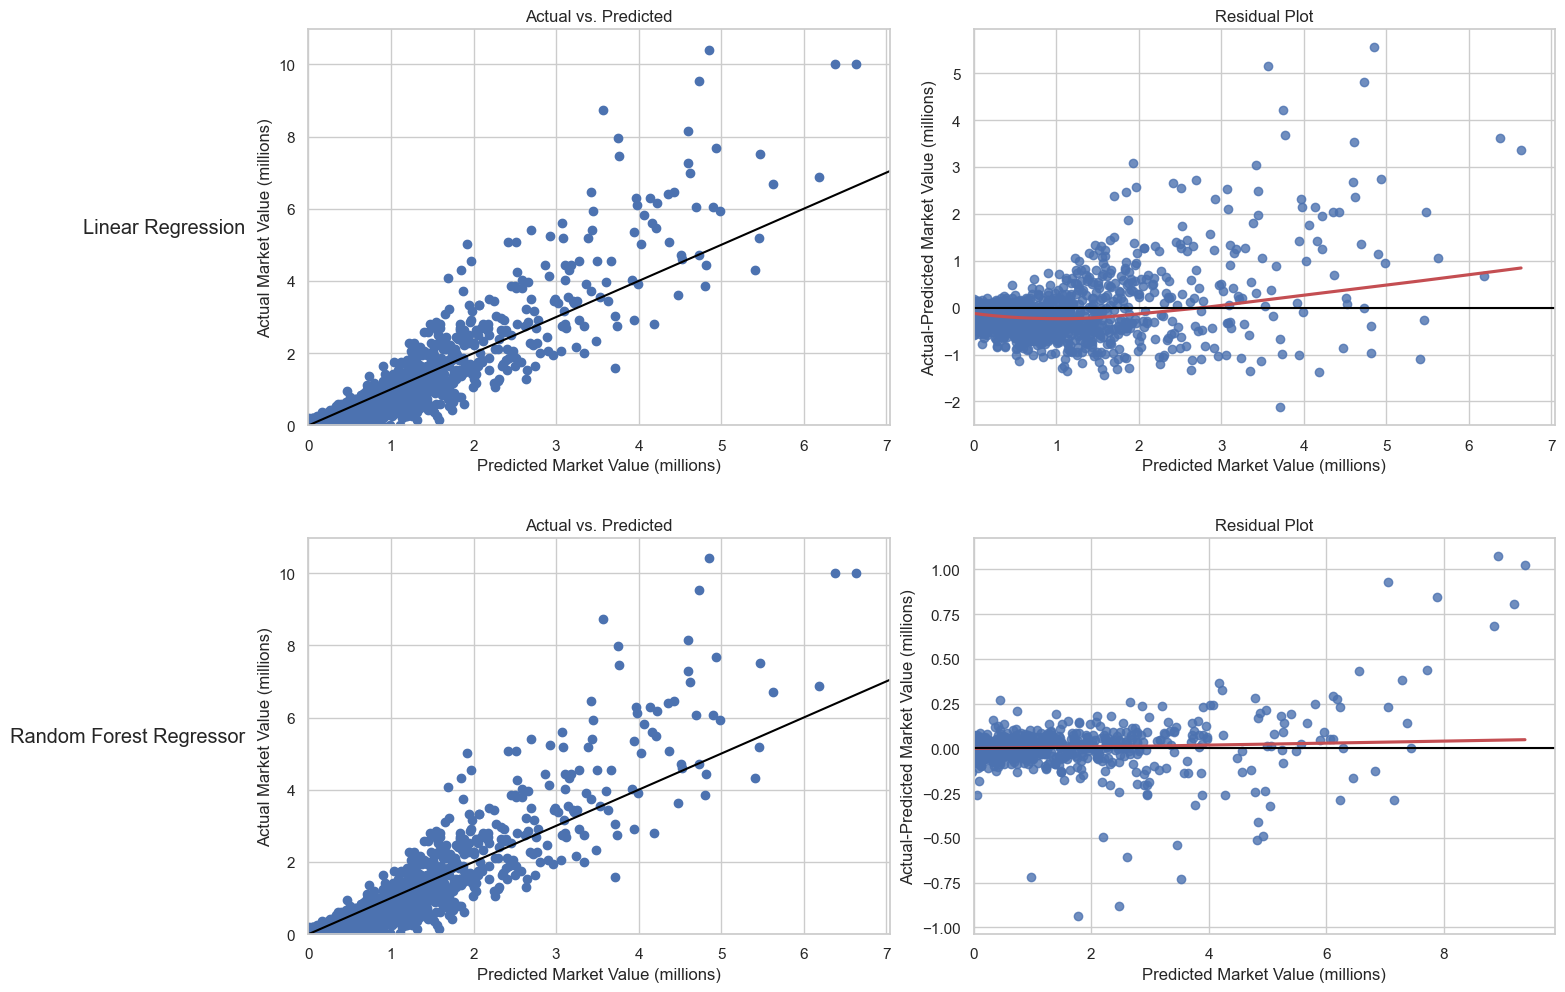

In [569]:
fig, axarr = plt.subplots(2, 2, figsize=(15,10), sharex = False, sharey = False)


rows = ["Linear Regression", "Random Forest Regressor"]
for ax, row in zip(axarr[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
fig.tight_layout(w_pad = 2, h_pad = 5)
fig.subplots_adjust(left=0.15, top=0.95)


    
#LR
Lol8.fit(X_train_value, y_train_value)
Lol8.predict(X_train_value)
predictions12 = Lol8.predict(X_train_value)
actual = y_train_value

difference = np.subtract(actual, predictions12)

#plot actual vs. prediction + paramater line
axarr[0,0].axline((0, 0), slope=1, color = "black")
axarr[0,0].scatter(x = predictions12, y = actual)
axarr[0,0].axis(xmin=0,ymin=0)

#plot the residuals
sns.regplot(x = predictions12, y = difference, lowess=True, line_kws=dict(color="r"), ax = axarr[0,1])
axarr[0,1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[0,1].axis(xmin=0)



#graph descriptives
labs = axarr[0,0].set(title = "Actual vs. Predicted", xlabel = "Predicted Market Value (millions)", ylabel = "Actual Market Value (millions)")
labs = axarr[0,1].set(title = "Residual Plot", xlabel = "Predicted Market Value (millions)", ylabel = "Actual-Predicted Market Value (millions)") #add legend


#RFR
regr.fit(X_train_value, y_train_value)
regr.predict(X_train_value)
predictions123 = regr.predict(X_train_value)
actual = y_train_value

difference = np.subtract(actual, predictions123)

#plot actual vs. prediction + paramater line
axarr[1,0].axline((0, 0), slope=1, color = "black")
axarr[1,0].scatter(x = predictions12, y = actual)
axarr[1,0].axis(xmin=0,ymin=0)

#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = predictions123, y = difference, lowess=True, line_kws=dict(color="r"))
axarr[1,1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1,1].axis(xmin=0)

#graph descriptions
labs = axarr[1,0].set(title = "Actual vs. Predicted", xlabel = "Predicted Market Value (millions)", ylabel = "Actual Market Value (millions)")
labs = axarr[1,1].set(title = "Residual Plot", xlabel = "Predicted Market Value (millions)", ylabel = "Actual-Predicted Market Value (millions)") #add legend

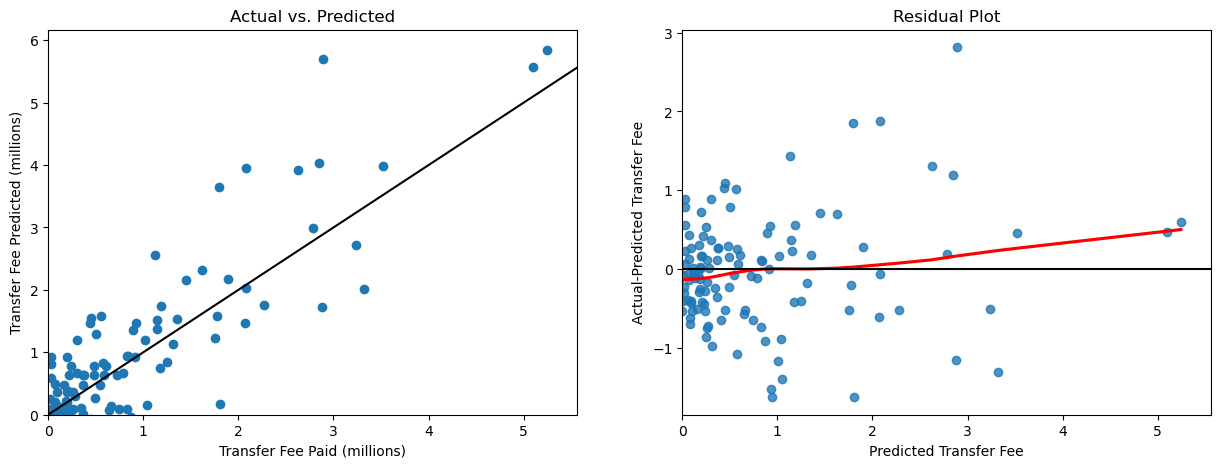

In [123]:
predictions2 = Lassolr99.predict(X_train_fee)
actual = y_train_fee


#add this to bias


difference = np.subtract(actual, predictions2)


x_axis_1 = np.linspace(0, len(predictions2), num = len(predictions2))
x_axis_2 = np.linspace(0, len(predictions2), num = len(predictions2))

#length of predictions and actual are the same
x_axis_3 = np.linspace(0, actual.shape[0], actual.shape[0])



fig, axarr = plt.subplots(1, 2, figsize=(15,5), sharex = False, sharey = False)

#plot actual vs. prediction + paramater line
axarr[0].axline((0, 0), slope=1, color = "black")
axarr[0].scatter(x = predictions2, y = actual)
axarr[0].axis(xmin=0,ymin=0)





#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = predictions2, y = difference, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)


labs = axarr[0].set(title = "Actual vs. Predicted", xlabel = "Transfer Fee Paid (millions)", ylabel = "Transfer Fee Predicted (millions)")
labs = axarr[1].set(title = "Residual Plot", xlabel = "Predicted Transfer Fee", ylabel = "Actual-Predicted Transfer Fee") #add legend


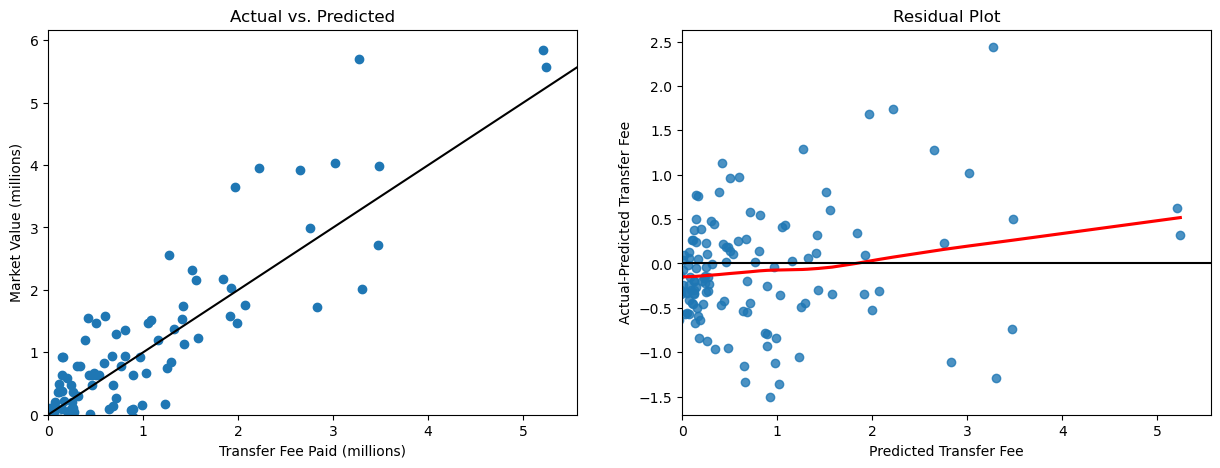

In [124]:
predictions3 = lr.predict(X_train_fee)
actual = y_train_fee


#add this to bias


difference = np.subtract(actual, predictions3)


x_axis_1 = np.linspace(0, len(predictions3), num = len(predictions3))
x_axis_2 = np.linspace(0, len(predictions3), num = len(predictions3))

#length of predictions and actual are the same
x_axis_3 = np.linspace(0, actual.shape[0], actual.shape[0])



fig, axarr = plt.subplots(1, 2, figsize=(15,5), sharex = False, sharey = False)

#plot actual vs. prediction + paramater line
axarr[0].axline((0, 0), slope=1, color = "black")
axarr[0].scatter(x = predictions3, y = actual)
axarr[0].axis(xmin=0,ymin=0)





#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = predictions3, y = difference, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)



labs = axarr[0].set(title = "Actual vs. Predicted", xlabel = "Transfer Fee Paid (millions)", ylabel = "Market Value (millions)")
labs = axarr[1].set(title = "Residual Plot", xlabel = "Predicted Transfer Fee", ylabel = "Actual-Predicted Transfer Fee") #add legend


## Model Comparisons + Cross-Validation + Hyperparameter Tuning https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Performance + Mini Experiment: Holdout Set Vs. Cross-Validation Method

In [138]:
lr_pf = []
Lasso_pf = []
rfr_pf = []

X_train_fee_sel = X_train_fee[['value_eur', 'overall', 'potential', 'wage_eur', 'passing',
       'goalkeeping_kicking', 'position_y', 'wins', 'missed', 'pts', 'xG',
       'npxG', 'xGA', 'npxGD', 'oppda_coef', 'deep', 'xpts', 'xpts_diff',
       'SPI', 'tranfer_activity', 'fee_cleaned_buyer_avg',
       'fee_cleaned_seller_avg']]

X_test_fee_sel = X_test_fee[['value_eur', 'overall', 'potential', 'wage_eur', 'passing',
       'goalkeeping_kicking', 'position_y', 'wins', 'missed', 'pts', 'xG',
       'npxG', 'xGA', 'npxGD', 'oppda_coef', 'deep', 'xpts', 'xpts_diff',
       'SPI', 'tranfer_activity', 'fee_cleaned_buyer_avg',
       'fee_cleaned_seller_avg']]

for i in range(1,10):
    from sklearn.model_selection import train_test_split
    field_tf_upd_train, field_tf_upd_test = train_test_split(tf2_data_field, test_size = .2, shuffle = True)

    #getting the feature matrix and target vector
    # field_tf_upd_train = field_tf_upd_train[field_tf_upd_train.columns[0:8]] #use this!!!
    # field_tf_upd_test = field_tf_upd_test[field_tf_upd_test.columns[0:8]] #use this!!!



    #re-clean; non-numerical stuff
    field_tf_upd_train = field_tf_upd_train.drop(["team"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["player_name"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["nationality_name"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["position_x"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["league_name_x_y"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["club_involved_name"], axis = 1)

    #re-clean; non-numerical stuff
    field_tf_upd_test = field_tf_upd_test.drop(["team"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["player_name"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["nationality_name"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["position_x"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["league_name_x_y"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["club_involved_name"], axis = 1)


    #TURN OFF FOR PREDICTIONS
    #standardized and back to df
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    field_tf_upd_train = pd.DataFrame(sc.fit_transform(field_tf_upd_train), columns = field_tf_upd_train.columns)


    sc = StandardScaler()
    field_tf_upd_test = pd.DataFrame(sc.fit_transform(field_tf_upd_test), columns = field_tf_upd_test.columns)


    X_train_fee = field_tf_upd_train.drop(["fee_cleaned"], axis = 1)
    y_train_fee = field_tf_upd_train["fee_cleaned"]

    X_test_fee = field_tf_upd_test.drop(["fee_cleaned"], axis = 1)
    y_test_fee = field_tf_upd_test["fee_cleaned"] # do this to get it by index; want to reset the index


    
    
    lr.fit(X_train_fee_sel, y_train_fee)
    lr.score(X_test_fee_sel, y_test_fee)

    from sklearn.model_selection import cross_val_score
    model_scores = cross_val_score(lr, X_train_fee_sel, y_train_fee, cv=5)
    lr_pf.append((model_scores.mean()))
    
    Lassolr99 = Lasso(alpha = 0.005)
    Lassolr99.fit(X_train_fee, y_train_fee)
    model_scores = cross_val_score(Lassolr99, X_train_fee, y_train_fee, cv=5)
    Lasso_pf.append(model_scores.mean())
    
    regr = RandomForestRegressor(max_depth = 11, random_state=0)
    regr.fit(X_train_fee, y_train_fee)
    model_scores = cross_val_score(regr, X_train_fee, y_train_fee, cv=5)
    rfr_pf.append(model_scores.mean())




In [139]:
print(np.mean(lr_pf))
print(np.mean(Lasso_pf))
print(np.mean(rfr_pf))

-0.1268773090295002
0.63520543291876
0.642731242587884


## Learning Curves (by models)

In [395]:
X_train_fee.iloc[0:3]

,AVGage,Foreigners,Pos,GP,W,D,L,GD,Points,Age,...,Base_stats,Weak_foot,Skill_moves,Pace_Diving,Shooting_Handling,Passing_Kicking,Dribbling_Reflexes,Defending_Pace,Physical_Positioning,Years_Left
48,26.4,26,9,38,15,7,16,3,52,24,...,423,4,4,71,70,77,78,61,66,2.0
87,24.4,22,5,38,19,11,8,19,68,20,...,415,3,3,71,70,72,74,64,64,2.0
175,25.4,20,4,38,23,2,13,28,71,20,...,436,2,4,89,75,74,85,40,73,4.0


In [375]:
import warnings
warnings.filterwarnings('ignore')

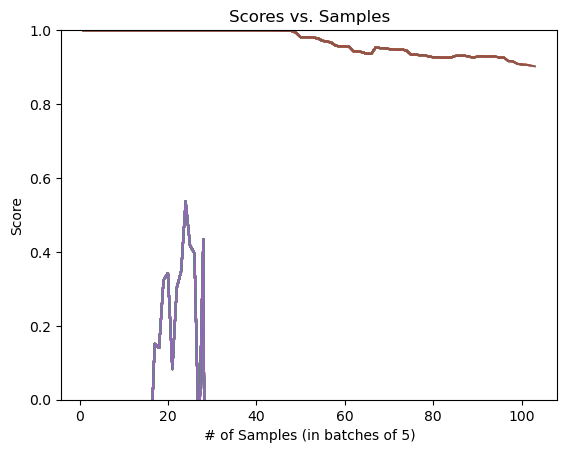

In [399]:
#effect of overfitting, keeping # features constant and increasing samples (good for when we get new dataset);

#effect of overfitting, keeping # samples constant and increasing features (good for when we get new dataset);


#initialize arrays to store scores
train_score_hist = []
cv_score_hist = []


#loop through samples:
for i in range(5, len(X_train_fee)):
    #fit on training; I don't think I should refit everytime!!!!!
    L6 = Lasso(alpha = 1) 
    L6.fit(X_train_fee.iloc[0:i], y_train_fee.iloc[0:i])
    
    #score on training
    #print(L6.score(X_train_fee.iloc[0:i],y_train_fee.iloc[0:i]))
    train_score_hist.append(L6.score(X_train_fee.iloc[0:i],y_train_fee.iloc[0:i]))  #update model's training score
    
    #cross-validation
    cv_score_hist.append(cross_val_score(L6, X_train_fee.iloc[0:i], y_train_fee.iloc[0:i], cv=5).mean())
 

    #Graph it
    num_steps = len(train_score_hist)
    plt.plot(np.arange(num_steps) + 1, cv_score_hist, label = "cross_val")

    num_steps = len(train_score_hist)
    plt.plot(np.arange(num_steps) + 1, train_score_hist, label = "train")

    plt.ylim([0, 1])
    #change x to be in batches of 5
    labels = plt.gca().set(title = "Scores vs. Samples", xlabel = "# of Samples (in batches of 5)", ylabel = "Score")


    
#loop through features:

#for i in rang

#effect of overfitting, w/ our # of samples, changing the number of features 

In [32]:
#comparison by Sample Size, # of features

## Bias Audit: Nationality

In [361]:
#new dataset with only these 5 coountries
#avg. tf for all these countries

#use England, Italy, Germany, France (European soccer powerhouses)

bias_tf_ds = tf2_data_field[tf2_data_field['nationality_name'].isin(['England', "Italy", "Germany","France"])]


bias_tf_ds.nationality_name.value_counts()

France     87
Italy      64
Germany    58
England    32
Name: nationality_name, dtype: int64

In [225]:
bias_tf_ds.head(3)

,age,fee_cleaned,value_eur,years_left,team,player_name,overall,potential,wage_eur,nationality_name,...,npxGA,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff,SPI,tranfer_activity
1,22,16500000.0,3800000.0,2,Barcelona,Lucas Digne,76,83,70000.0,France,...,33.285940,66.191080,6.012152,15.064390,570,163,94.3800,3.3800,67.72,-487.0
2,25,1500000.0,425000.0,3,Eibar,Florian Lejeune,65,70,2000.0,France,...,47.452420,-0.608427,7.804410,7.974349,191,218,54.0253,11.0253,67.72,-487.0
6,25,9500000.0,5500000.0,1,Sevilla,Wissam Ben Yedder,77,81,50000.0,France,...,43.858446,13.909384,8.600500,8.957718,296,216,63.6363,11.6363,67.72,-487.0


In [226]:
bias_tf_ds_base = bias_tf_ds.groupby("nationality_name", as_index=False)["fee_cleaned"].mean()

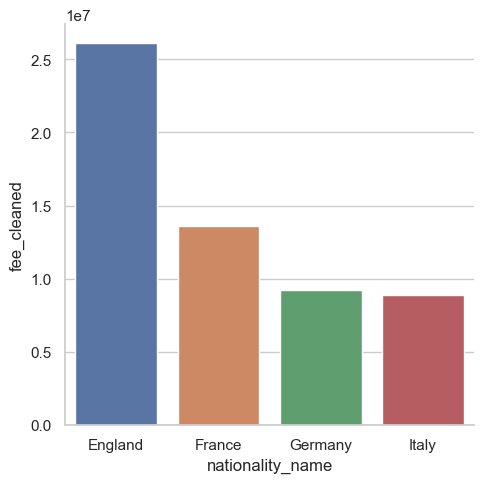

In [227]:
sns.set_theme(style="whitegrid")

p = sns.catplot(data = bias_tf_ds_base, kind = "bar", x = "nationality_name", y = "fee_cleaned", legend_out = False, ci = False)

In [228]:
bias_tf_ds.groupby("nationality_name")["fee_cleaned"].mean()

nationality_name
England    2.610156e+07
France     1.362586e+07
Germany    9.245431e+06
Italy      8.867656e+06
Name: fee_cleaned, dtype: float64

In [229]:
# field_tf_upd_test = pd.DataFrame(sc.inverse_transform(field_tf_upd_test), columns = field_tf_upd_test.columns) #reverse standardization
# X_test_fee = field_tf_upd_test.drop(["fee_cleaned"], axis = 1)
# y_test_fee = field_tf_upd_test["fee_cleaned"] # do this to get it by index; want to reset the index


# field_tf_upd_train = pd.DataFrame(sc.inverse_transform(field_tf_upd_train), columns = field_tf_upd_train.columns)
# X_train_fee = field_tf_upd_train.drop(["fee_cleaned"], axis = 1)
# y_train_fee = field_tf_upd_train["fee_cleaned"] # do this to get it by index; want to reset the index



# bias_tf_ds = field_tf_upd_test.copy()
# bias_tf_ds.rename(columns={'fee_cleaned_threshold':'Actual'}, inplace=True) #rename ValueThreshold to Actual

# #refit on non-standardized
# #re-predict on non-standardized
# regr.fit(X_train_fee, y_train_fee)
# bias_tf_ds["Predicted"] = regr.predict(X_test_fee)

# How Far off Predictions are by nation

# How High are the Predictions by nation

# SEPARATOR

In [230]:
from sklearn.model_selection import train_test_split
field_tf_bias_train, field_tf_bias_test = train_test_split(bias_tf_ds, test_size = .2, shuffle = True)

In [231]:
#Feature matrix 
#field_tf_bias_train = field_tf_bias_train.drop(["team"], axis = 1)
field_tf_bias_train = field_tf_bias_train.drop(["player_name"], axis = 1)
field_tf_bias_train = field_tf_bias_train.drop(["position_x"], axis = 1)
field_tf_bias_train = field_tf_bias_train.drop(["league_name_x_y"], axis = 1)
#field_tf_bias_train = field_tf_bias_train.drop(["club_involved_name"], axis = 1)
#field_tf_bias_train = field_tf_bias_train.drop(["fee_cleaned"], axis = 1)


#field_tf_bias_test = field_tf_bias_test.drop(["team"], axis = 1)
field_tf_bias_test = field_tf_bias_test.drop(["player_name"], axis = 1)
field_tf_bias_test = field_tf_bias_test.drop(["position_x"], axis = 1)
field_tf_bias_test = field_tf_bias_test.drop(["league_name_x_y"], axis = 1)
#field_tf_bias_test = field_tf_bias_test.drop(["club_involved_name"], axis = 1)
#field_tf_bias_test = field_tf_bias_test.drop(["fee_cleaned"], axis = 1)

#feature engineering on training data
buyer_avg_tf = field_tf_bias_train.groupby("team")["fee_cleaned"].mean()
seller_avg_tf = field_tf_bias_train.groupby("club_involved_name")["fee_cleaned"].mean()

#left-merge based on "team names"; preserves all rows of tf2_data_field and merges with buyer_avg_tf on matches on "team"
field_tf_bias_train = pd.merge(field_tf_bias_train, buyer_avg_tf, on='team', how='left', suffixes=('', '_buyer_avg'))
field_tf_bias_train = pd.merge(field_tf_bias_train, seller_avg_tf, on='club_involved_name', how='left', suffixes=('', '_seller_avg'))

#drop the categorical features we used for feature engineering
field_tf_bias_train = field_tf_bias_train.drop(["team"], axis = 1)
field_tf_bias_train = field_tf_bias_train.drop(["club_involved_name"], axis = 1)


#feature engineering on testing data (added after improved performance on cross-validated scores was observed)
buyer_avg_tf = field_tf_bias_test.groupby("team")["fee_cleaned"].mean()
seller_avg_tf = field_tf_bias_test.groupby("club_involved_name")["fee_cleaned"].mean()

#left-merge based on "team names"; preserves all rows of tf2_data_field and merges with buyer_avg_tf on matches on "team"
field_tf_bias_test = pd.merge(field_tf_bias_test, buyer_avg_tf, on='team', how='left', suffixes=('', '_buyer_avg'))
field_tf_bias_test = pd.merge(field_tf_bias_test, seller_avg_tf, on='club_involved_name', how='left', suffixes=('', '_seller_avg'))

#drop the categorical features we used for feature engineering
field_tf_bias_test = field_tf_bias_test.drop(["team"], axis = 1)
field_tf_bias_test = field_tf_bias_test.drop(["club_involved_name"], axis = 1)



#Getting feature matrix and target vector for train, test
X_tf_bias_train = field_tf_bias_train.drop(["fee_cleaned"], axis = 1)
X_tf_bias_train = X_tf_bias_train.drop(["nationality_name"], axis = 1)
y_tf_bias_train = field_tf_bias_train["fee_cleaned"]

X_tf_bias_test = field_tf_bias_test.drop(["fee_cleaned"], axis = 1)
X_tf_bias_test = X_tf_bias_test.drop(["nationality_name"], axis = 1)
y_tf_bias_test = field_tf_bias_test["fee_cleaned"]

In [398]:
X_tf_bias_train.head(1)

,age,value_eur,years_left,overall,potential,wage_eur,weak_foot,skill_moves,international_reputation,pace,...,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff,SPI,tranfer_activity,fee_cleaned_buyer_avg,fee_cleaned_seller_avg
0,28,21000000.00,2,81,82,40000.00,3,3,2,79.00,...,7.60,8.57,219,215,49.84,-13.16,62.98,-804.00,8076000.00,9550000.00


In [239]:
#use regression model
# from sklearn.ensemble import RandomForestRegressor
# regr = RandomForestRegressor(max_depth = 40, random_state=0)
# regr.fit(X_tf_bias_train, y_tf_bias_train)
model_scores = cross_val_score(regr, X_tf_bias_train, y_tf_bias_train, cv = 10)
print(model_scores.mean())

0.6384040062544442


In [257]:
bias_ds2 = field_tf_bias_train.copy()
bias_ds2.rename(columns={'fee_cleaned':'Actual'}, inplace=True)
bias_ds2["Predicted"] = regr.predict(X_tf_bias_train)

In [258]:
bias_ds2

,age,Actual,value_eur,years_left,overall,potential,wage_eur,nationality_name,weak_foot,skill_moves,...,oppda_coef,deep,deep_allowed,xpts,xpts_diff,SPI,tranfer_activity,fee_cleaned_buyer_avg,fee_cleaned_seller_avg,Predicted
0,28,12000000.00,21000000.00,2,81,82,40000.00,Italy,3,3,...,8.57,219,215,49.84,-13.16,62.98,-804.00,8076000.00,9550000.00,11012970.81
1,27,22000000.00,20500000.00,3,81,87,60000.00,France,3,3,...,10.88,203,215,55.78,6.78,71.92,-5449.00,16028571.43,10333333.33,17884366.20
2,25,5000000.00,3900000.00,1,74,80,20000.00,France,3,2,...,10.21,139,237,34.80,1.80,68.62,-41.00,6166666.67,5000000.00,5111712.08
3,25,3200000.00,950000.00,1,67,70,15000.00,Germany,3,3,...,9.42,150,168,51.69,-11.31,68.62,-41.00,5625000.00,2100000.00,2931304.98
4,22,1500000.00,1400000.00,1,69,78,10000.00,France,2,2,...,9.45,122,213,45.49,8.49,61.30,360.60,1750000.00,3300000.00,1915604.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,23,24000000.00,450000.00,2,63,72,4000.00,Italy,2,2,...,12.07,244,222,58.88,-4.12,62.98,-804.00,16807000.00,12500000.00,19353767.10
188,22,5750000.00,3700000.00,2,71,83,10000.00,Italy,4,3,...,8.94,202,304,41.83,-7.17,62.98,-804.00,3243333.33,10375000.00,5686331.00
189,24,5000000.00,4500000.00,2,72,82,20000.00,France,3,3,...,12.22,233,178,53.00,-7.00,62.98,-804.00,16807000.00,17375000.00,15531369.90
190,28,8000000.00,17500000.00,2,80,81,40000.00,Italy,4,3,...,9.09,200,238,48.95,4.95,62.98,-804.00,5900000.00,4500000.00,4912610.46


In [259]:
bias_ds2_preds = bias_ds2.groupby(["nationality_name"], as_index=False)["Predicted"].mean()

In [260]:
bias_ds2_preds

,nationality_name,Predicted
0,England,19160904.10
1,France,14801928.89
2,Germany,9664065.13
3,Italy,9654791.76


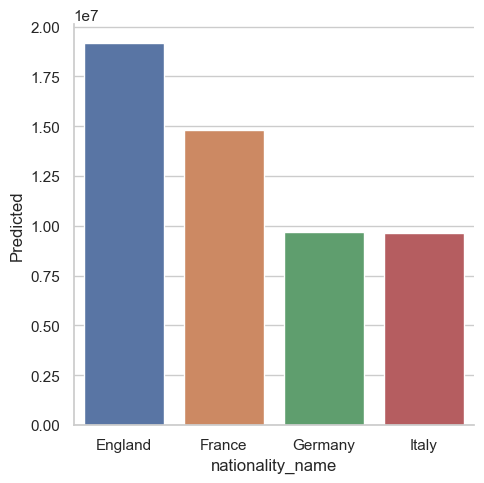

In [245]:
sns.set_theme(style="whitegrid")

p = sns.catplot(data = bias_ds2_preds, kind = "bar", x = "nationality_name", y = "Predicted", legend_out = False)

In [345]:
names = bias_ds2_preds["nationality_name"].drop_duplicates()
names = names.reset_index(drop=True)
names

0    England
1     France
2    Germany
3      Italy
Name: nationality_name, dtype: object

In [367]:
bias_ds2_act_pred = bias_ds2.groupby(["nationality_name"], as_index=False)["Actual","Predicted"].mean()

bias_ds2_residuals = pd.DataFrame(bias_ds2_act_pred.loc[:, 'Actual'] - bias_ds2_act_pred.loc[:, 'Predicted'], columns = ["Differences"])
bias_ds2_residuals["nationality_names"] = names


In [368]:
bias_ds2_residuals

,Differences,nationality_names
0,3539095.90,England
1,-134595.55,France
2,-505111.64,Germany
3,-1262.35,Italy


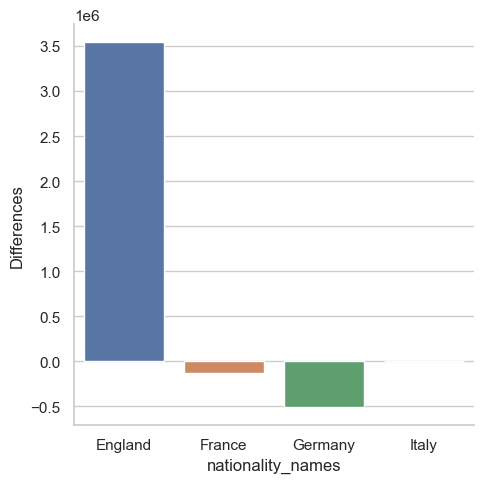

In [369]:
sns.set_theme(style="whitegrid")

p = sns.catplot(data = bias_ds2_residuals, kind = "bar", x = "nationality_names", y = "Differences", legend_out = False)

In [ ]:
#plot, find all resids for each nation

In [391]:
group_test = bias_ds2["nationality_name"]

In [392]:
England_resids = (bias_ds2[group_test == "England"]["Actual"]) - (bias_ds2[group_test == "England"]["Predicted"])
France_resids = (bias_ds2[group_test == "France"]["Actual"]) - (bias_ds2[group_test == "France"]["Predicted"])
Germany_resids = (bias_ds2[group_test == "Germany"]["Actual"]) - (bias_ds2[group_test == "Germany"]["Predicted"])
Italy_resids = (bias_ds2[group_test == "Italy"]["Actual"]) - (bias_ds2[group_test == "Italy"]["Predicted"])

(0.0, 5.561192392894468, -1.7049968840877454, 2.6335733746858283)

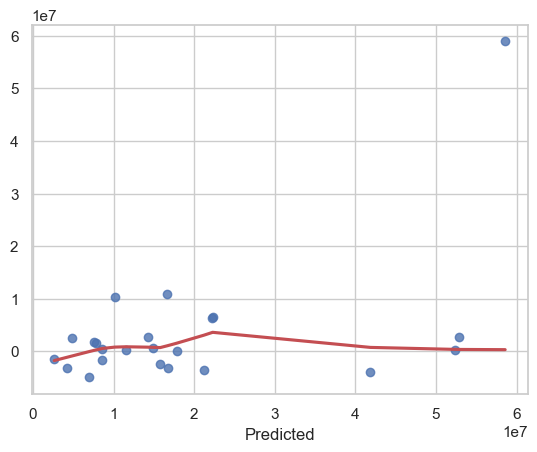

In [394]:
#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = bias_ds2[group_test == "England"]["Predicted"], y = England_resids, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)

(0.0, 5.561192392894468, -1.7049968840877454, 2.6335733746858283)

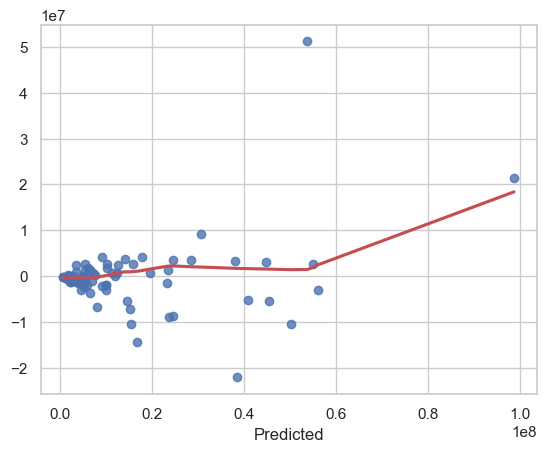

In [395]:
#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = bias_ds2[group_test == "France"]["Predicted"], y = France_resids, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)

(0.0, 5.561192392894468, -1.7049968840877454, 2.6335733746858283)

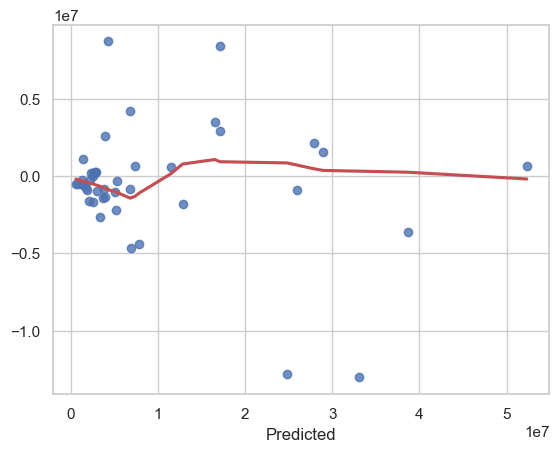

In [396]:
#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = bias_ds2[group_test == "Germany"]["Predicted"], y = Germany_resids, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)

(0.0, 5.561192392894468, -1.7049968840877454, 2.6335733746858283)

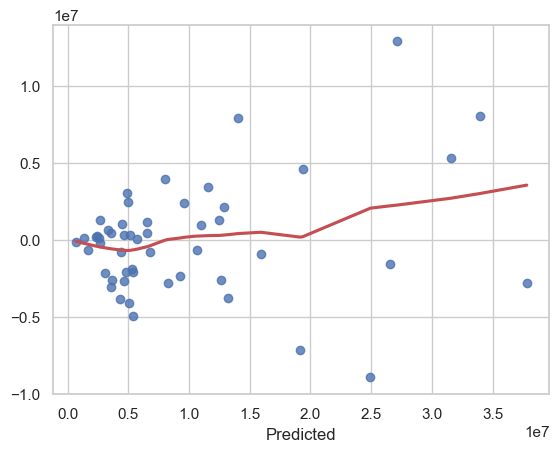

In [397]:
#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = bias_ds2[group_test == "Italy"]["Predicted"], y = Italy_resids, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)

In [ ]:
#find threshold for good / bad predictions; # of good vs. number of bad predictions